In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
from scipy import stats
from adjustText import adjust_text

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
adata = sc.read('annotated.h5ad')
adata.obs

samples condition location  n_genes  n_genes_by_counts  \
711_AAACCCAAGTCGGGAT-1     711     Tumor    Right      707                707   
711_AAACCCACAGAGGAAA-1     711     Tumor    Right      838                838   
711_AAACCCACATGATAGA-1     711     Tumor    Right      435                435   
711_AAACCCAGTCTCGCGA-1     711     Tumor    Right      579                579   
711_AAACGAAGTTATCTTC-1     711     Tumor    Right     1384               1384   
...                        ...       ...      ...      ...                ...   
706_TTTGGTTCAAACACCT-1     706     Tumor     Left     1815               1815   
706_TTTGGTTCAACGGGTA-1     706     Tumor     Left      909                909   
706_TTTGGTTTCTATCGCC-1     706     Tumor     Left     4658               4658   
706_TTTGTTGCATCAGCGC-1     706     Tumor     Left      374                374   
706_TTTGTTGGTTCCTTGC-1     706     Tumor     Left     1875               1875   

                        log1p_n_genes_by_counts  total_counts  \
711_AAACCCAAGTCGGGAT-1                 6.562444        1396.0   
711_AAACCCACAGAGGAAA-1                 6.732211        1504.0   
711_AAACCCACATGATAGA-1                 6.077642         613.0   
711_AAACCCAGTCTCGCGA-1                 6.363028         860.0   
711_AAACGAAGTTATCTTC-1                 7.233455        2629.0   
...                                         ...           ...   
706_TTTGGTTCAAACACCT-1                 7.504392        4944.0   
706_TTTGGTTCAACGGGTA-1                 6.813445        3528.0   
706_TTTGGTTTCTATCGCC-1                 8.446556       23600.0   
706_TTTGTTGCATCAGCGC-1                 5.926926         686.0   
706_TTTGTTGGTTCCTTGC-1                 7.536897        4189.0   

                        log1p_total_counts  pct_counts_in_top_20_genes  \
711_AAACCCAAGTCGGGAT-1            7.242083                   26.862464   
711_AAACCCACAGAGGAAA-1            7.316548                   23.803191   
711_AAACCCACATGATAGA-1            6.419995                   17.781403   
711_AAACCCAGTCTCGCGA-1            6.758094                   23.255814   
711_AAACGAAGTTATCTTC-1            7.874739                   19.246862   
...                                    ...                         ...   
706_TTTGGTTCAAACACCT-1            8.506132                   21.318770   
706_TTTGGTTCAACGGGTA-1            8.168770                   34.722222   
706_TTTGGTTTCTATCGCC-1           10.069044                   17.559322   
706_TTTGTTGCATCAGCGC-1            6.532334                   23.032070   
706_TTTGTTGGTTCCTTGC-1            8.340456                   22.177131   

                        pct_counts_mt  pct_counts_ribo  pct_counts_hb  \
711_AAACCCAAGTCGGGAT-1      10.100286        25.716331       0.000000   
711_AAACCCACAGAGGAAA-1       9.441490        13.962767       0.000000   
711_AAACCCACATGATAGA-1       0.815661        18.270800       0.000000   
711_AAACCCAGTCTCGCGA-1      15.465117         6.395349       0.000000   
711_AAACGAAGTTATCTTC-1       8.178015        15.405098       0.000000   
...                               ...              ...            ...   
706_TTTGGTTCAAACACCT-1       1.961974        21.318771       0.020227   
706_TTTGGTTCAACGGGTA-1       0.368481        25.368483       0.000000   
706_TTTGGTTTCTATCGCC-1       3.237288        18.135593       0.004237   
706_TTTGTTGCATCAGCGC-1      10.932944        33.236153       0.000000   
706_TTTGTTGGTTCCTTGC-1       6.182860        12.628312       0.000000   

                                        low_label  low_score  _scvi_batch  \
711_AAACCCAAGTCGGGAT-1  T follicular helper cells   0.103311            0   
711_AAACCCACAGAGGAAA-1                    Unknown   0.236022            0   
711_AAACCCACATGATAGA-1                    Unknown   0.400460            0   
711_AAACCCAGTCTCGCGA-1               Tip-like ECs   0.966648            0   
711_AAACGAAGTTATCTTC-1        gamma delta T cells   0.993837            0   
...                                      

In [8]:
# Use the full adata (not adata_tumor) since we need both tumor and normal
cell_types = adata.obs['Cell_Type'].unique()
deg_results = {}

print(f"Found {len(cell_types)} cell types")
print(f"All Cells DEG analysis...\n")

for cell_type in cell_types:
    print(f"{'='*60}")
    print(f"Analyzing {cell_type}...")
    print(f"{'='*60}")
    
    # Subset to only this cell type
    adata_subset = adata[adata.obs['Cell_Type'] == cell_type].copy()
    

    

    # Run DEG analysis comparing tumor vs normal
    sc.tl.rank_genes_groups(
        adata_subset,
        groupby='Cell_Type',
        method='wilcoxon'        # Wilcoxon rank-sum test
    )
    
    # Extract results
    deg_df = sc.get.rank_genes_groups_df(
        adata_subset, 
        group ='Cell_type'
    )
    
    # Add metadata
    deg_df['Cell_Type'] = cell_type
    
    deg_results[cell_type] = deg_df
    
    print(f"  ✅ Tested {len(deg_df)} genes\n")

# Combine all results
if deg_results:
    all_degs = pd.concat(deg_results.values(), ignore_index=True)
    
    print(f"{'='*60}")
    print(f"COMBINED RESULTS")
    print(f"{'='*60}")
    print(f"Total genes tested: {len(all_degs)}")
    print(f"Cell types analyzed: {len(deg_results)}")
    
    # Filter by criteria
    significant_degs = all_degs[
        (all_degs['pvals_adj'] < 0.05) & 
        (abs(all_degs['logfoldchanges']) > 0.5)
    ]
    
    print(f"\nSignificant DEGs (p_adj < 0.05, |log2FC| > 0.5): {len(significant_degs)}")
    
    # Summary per cell type
    print(f"\nDEGs per cell type:")
    summary = significant_degs.groupby('Cell_Type').size().sort_values(ascending=False)
    print(summary)
    
    # Save results
    all_degs.to_csv('DEGs_all.csv', index=False)
    significant_degs.to_csv('DEGs_significant_all.csv', index=False)
    
    print(f"\n✅ Results saved:")
    
else:
    print("❌ No DEG results generated!")

Found 21 cell types
All Cells DEG analysis...

Analyzing CD4+ T Cells...


KeyError: "None of [Index(['Cell_type'], dtype='object')] are in the [columns]"

In [9]:

# Get all unique cell types
cell_types = adata.obs['Cell_Type'].unique()

print(f"Found {len(cell_types)} cell types")
print(f"Running pairwise comparisons between all cell types...\n")

# Option 1: Compare each cell type vs all other cell types
# =========================================================

deg_results = {}

for cell_type in cell_types:
    print(f"{'='*60}")
    print(f"Analyzing {cell_type} vs rest...")
    print(f"{'='*60}")
    
    n_cells = (adata.obs['Cell_Type'] == cell_type).sum()
    print(f"  {cell_type}: {n_cells} cells")
    
    if n_cells < 10:
        print(f"  ⚠️ Skipping - too few cells\n")
        continue
    
    # Run DEG: this cell type vs all others
    sc.tl.rank_genes_groups(
        adata,
        groupby='Cell_Type',
        groups=[cell_type],
        reference='rest',  # Compare to all other cell types
        method='wilcoxon',
        key_added=f'deg_{cell_type}'
    )
    
    # Extract results
    deg_df = sc.get.rank_genes_groups_df(
        adata,
        group=cell_type,
        key=f'deg_{cell_type}'
    )
    
    # Add metadata
    deg_df['Cell_Type'] = cell_type
    deg_df['n_cells'] = n_cells
    deg_df['comparison'] = f'{cell_type}_vs_rest'
    
    deg_results[cell_type] = deg_df
    
    print(f"  ✅ Tested {len(deg_df)} genes\n")

# Combine all results
if deg_results:
    all_degs = pd.concat(deg_results.values(), ignore_index=True)
    
    print(f"{'='*60}")
    print(f"RESULTS SUMMARY")
    print(f"{'='*60}")
    print(f"Total comparisons: {len(deg_results)}")
    print(f"Total genes tested: {len(all_degs)}")
    
    # Filter significant genes
    significant_degs = all_degs[
        (all_degs['pvals_adj'] < 0.05) & 
        (abs(all_degs['logfoldchanges']) > 0.5)
    ]
    
    print(f"\nSignificant DEGs (p_adj < 0.05, |log2FC| > 0.5): {len(significant_degs)}")
    
    # Top markers per cell type
    print(f"\nTop marker genes per cell type:")
    for cell_type in cell_types:
        ct_degs = significant_degs[significant_degs['Cell_Type'] == cell_type]
        if len(ct_degs) > 0:
            top_genes = ct_degs.nlargest(5, 'logfoldchanges')['names'].tolist()
            print(f"  {cell_type}: {', '.join(top_genes)}")
    
    # Save results
    all_degs.to_csv('celltype_markers_all.csv', index=False)
    significant_degs.to_csv('celltype_markers_significant.csv', index=False)
    
    print(f"\n✅ Results saved:")
    print(f"   - celltype_markers_all.csv")
    print(f"   - celltype_markers_significant.csv")
else:
    print("❌ No results generated!")

Found 21 cell types
Running pairwise comparisons between all cell types...

Analyzing CD4+ T Cells vs rest...
  CD4+ T Cells: 17357 cells
  ✅ Tested 14469 genes

Analyzing CMS3 vs rest...
  CMS3: 3876 cells
  ✅ Tested 14469 genes

Analyzing Tip-like ECs vs rest...
  Tip-like ECs: 610 cells
  ✅ Tested 14469 genes

Analyzing CD8+ T cells vs rest...
  CD8+ T cells: 6676 cells
  ✅ Tested 14469 genes

Analyzing B Cells vs rest...
  B Cells: 10774 cells
  ✅ Tested 14469 genes

Analyzing Spp1+ vs rest...
  Spp1+: 1634 cells
  ✅ Tested 14469 genes

Analyzing Mast cells vs rest...
  Mast cells: 642 cells
  ✅ Tested 14469 genes

Analyzing Stromal 2 vs rest...
  Stromal 2: 897 cells
  ✅ Tested 14469 genes

Analyzing CMS2 vs rest...
  CMS2: 1792 cells
  ✅ Tested 14469 genes

Analyzing Regulatory T Cells vs rest...
  Regulatory T Cells: 3907 cells
  ✅ Tested 14469 genes

Analyzing Pericytes vs rest...
  Pericytes: 457 cells
  ✅ Tested 14469 genes

Analyzing Dendritic cells vs rest...
  Dendritic ce

Total unique marker genes: 105


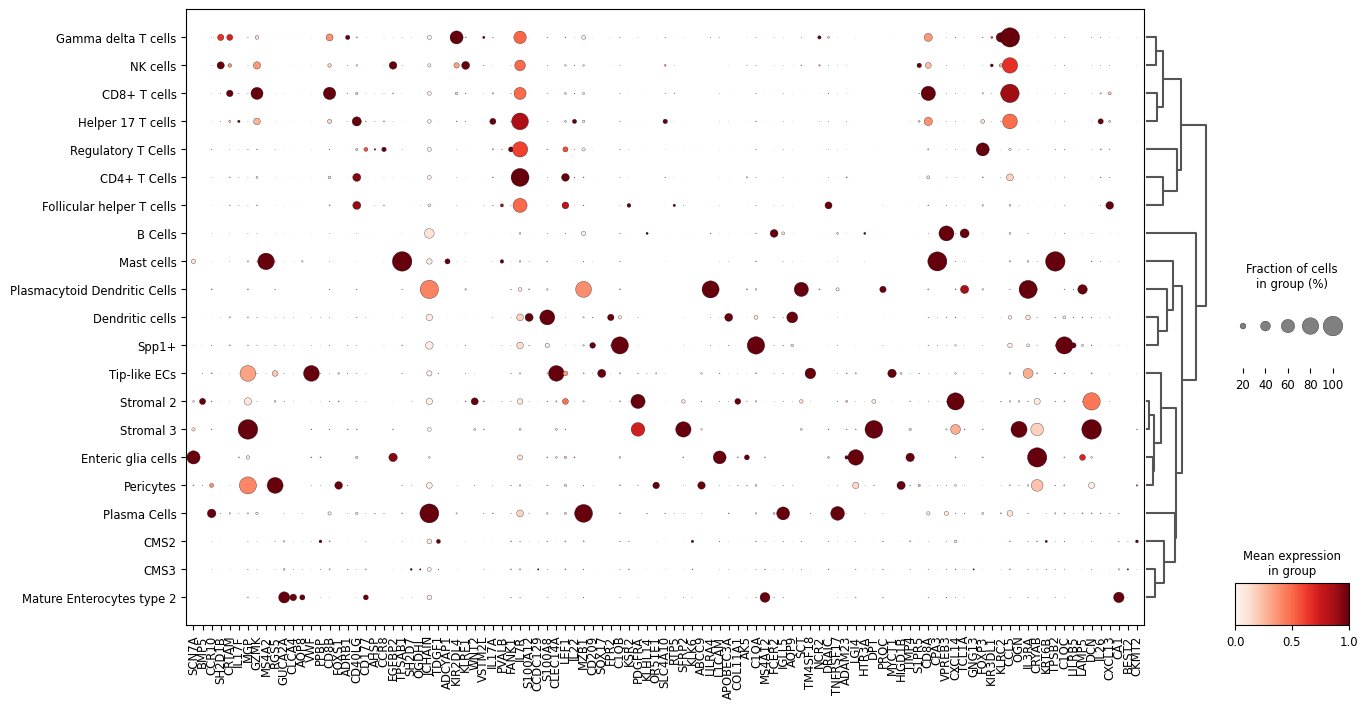

AttributeError: AxesImage.set() got an unexpected keyword argument 'dendrogram_show'

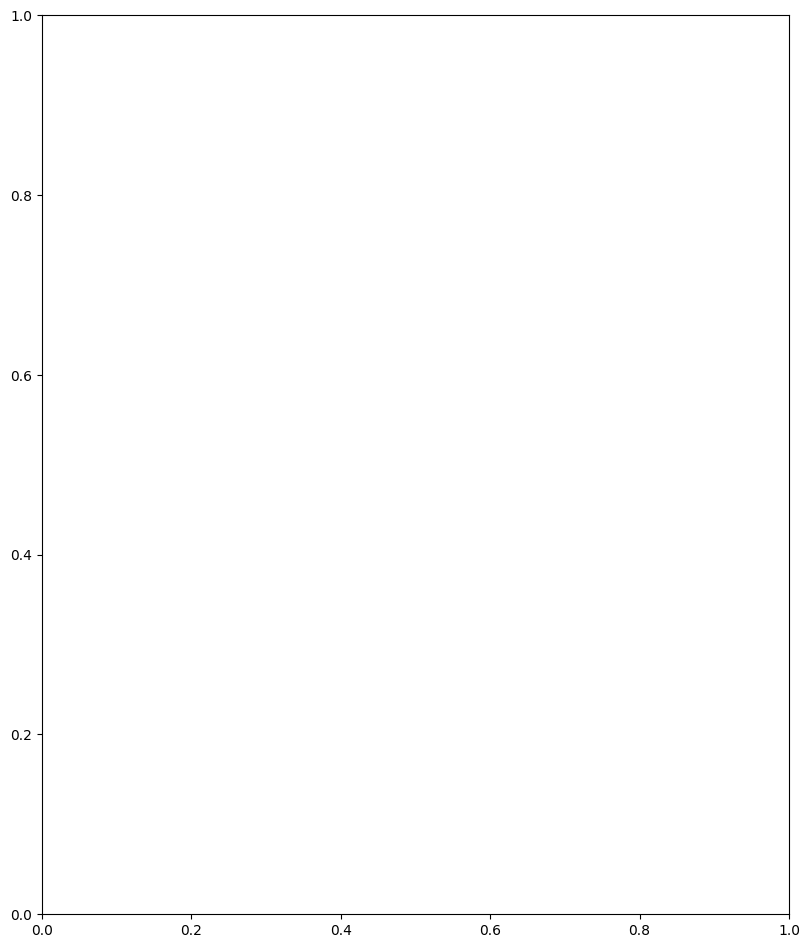

In [13]:
# Stringent filtering for true markers
markers = all_degs[
    (all_degs['pvals_adj'] < 0.01) &          # More stringent p-value
    (all_degs['logfoldchanges'] > 1)  
    ]
# Get top 5 markers per cell type
top_markers = {}
for cell_type in adata.obs['Cell_Type'].unique():
    ct_markers = markers[markers['Cell_Type'] == cell_type]
    top5 = ct_markers.nlargest(5, 'logfoldchanges')['names'].tolist()
    top_markers[cell_type] = top5

# Flatten to unique genes
all_marker_genes = list(set([gene for genes in top_markers.values() for gene in genes]))

print(f"Total unique marker genes: {len(all_marker_genes)}")

# Dotplot
sc.pl.dotplot(
    adata,
    var_names=all_marker_genes,
    groupby='Cell_Type',
    dendrogram=True,
    standard_scale='var',
    figsize=(15, 8),
    save='_celltype_markers.pdf'
)

# Heatmap
sc.pl.heatmap(
    adata,
    var_names=all_marker_genes,
    groupby='Cell_Type',
    dendrogram_show=True,
    swap_axes=True,
    figsize=(10, 12),
    save='_celltype_markers.pdf'
)

# Violin plots for top markers
for cell_type, genes in list(top_markers.items())[:3]:  # First 3 cell types
    sc.pl.violin(
        adata,
        keys=genes,
        groupby='Cell_Type',
        rotation=45,
        save=f'_{cell_type.replace(" ", "_")}_markers.pdf'
    )

Creating volcano plots for each cell type...

Plotting CD4+ T Cells...


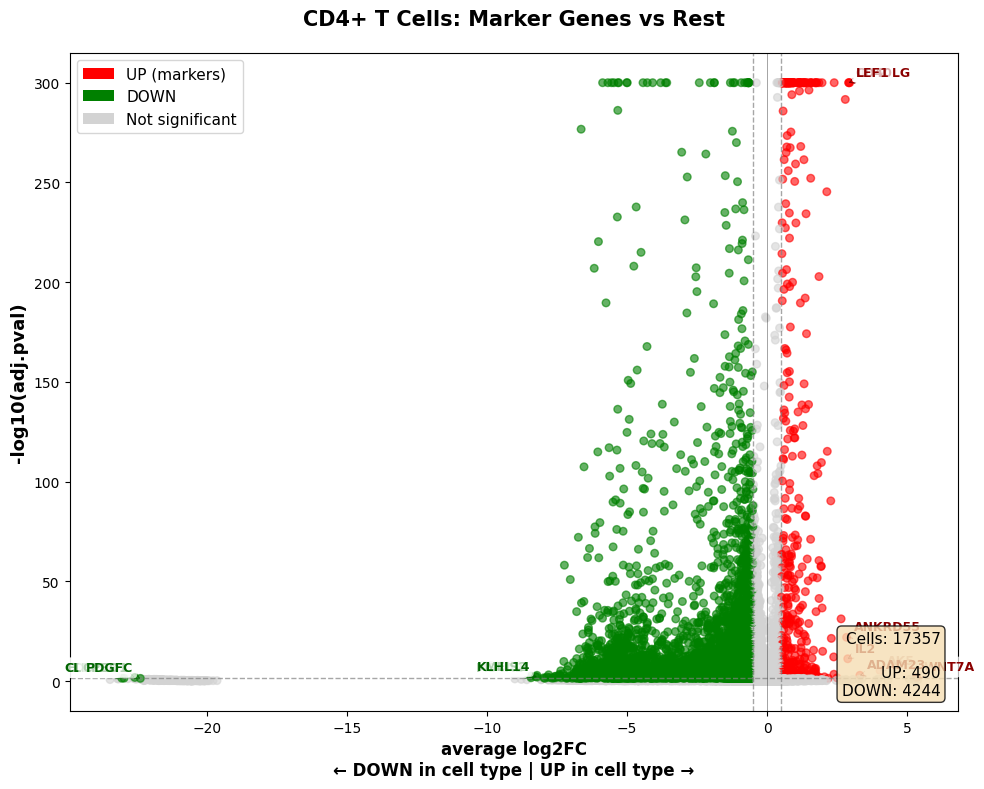

  ✅ Saved volcano plot

Plotting CMS3...


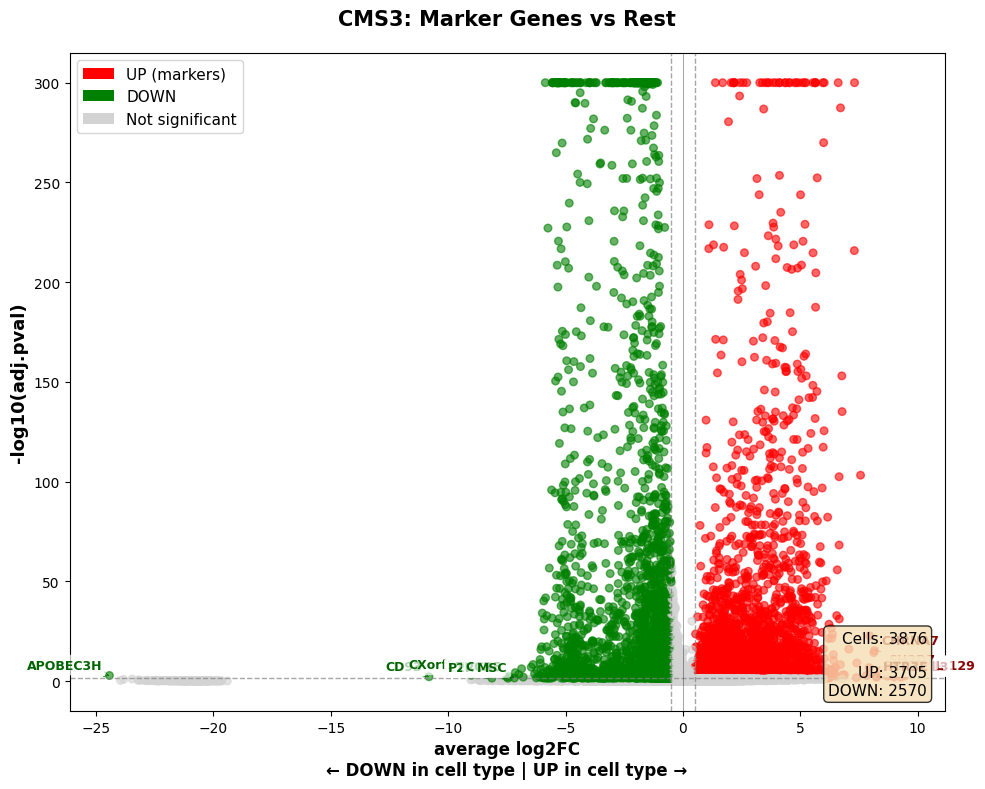

  ✅ Saved volcano plot

Plotting Tip-like ECs...


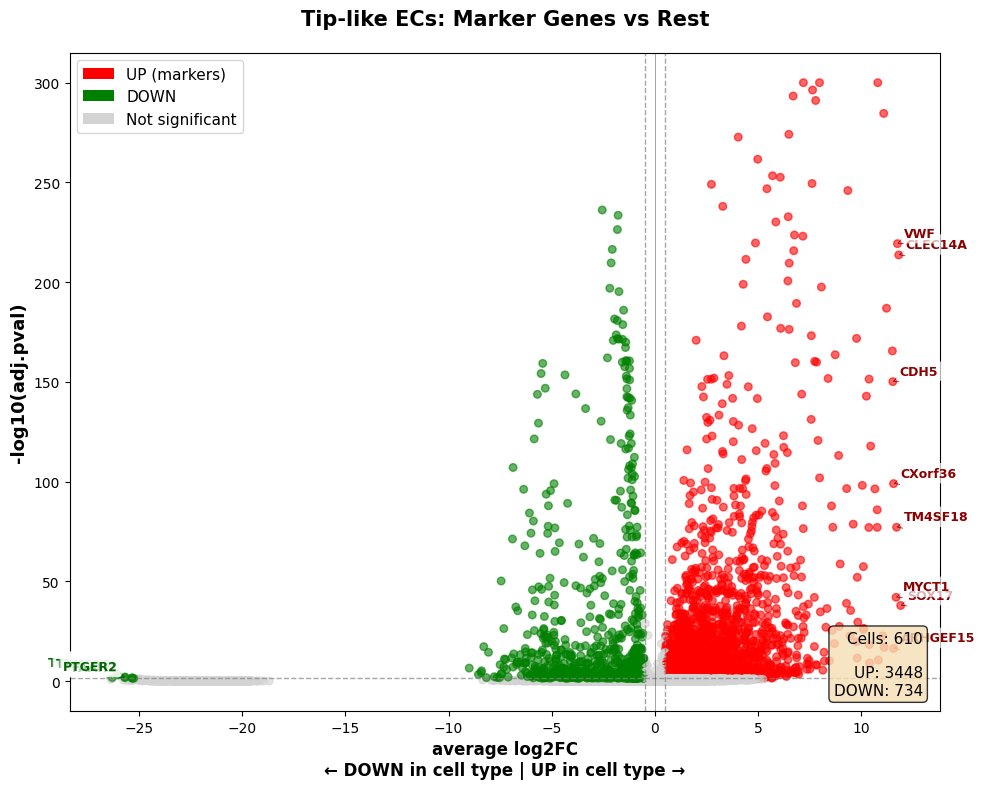

  ✅ Saved volcano plot

Plotting CD8+ T cells...


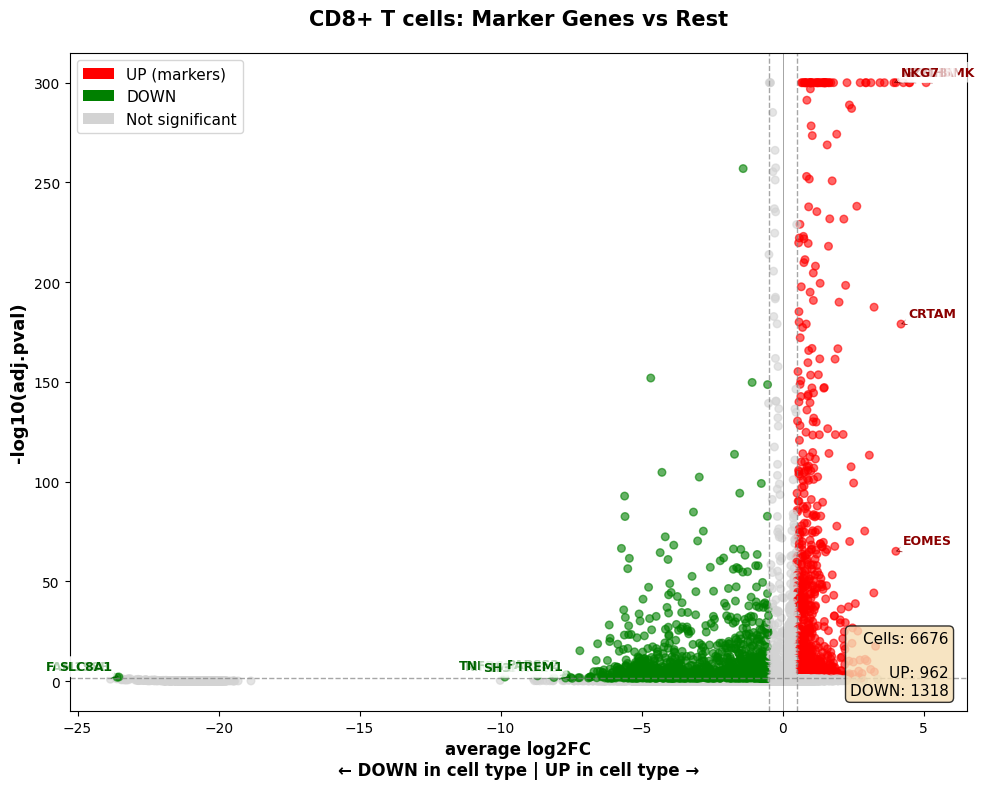

  ✅ Saved volcano plot

Plotting B Cells...


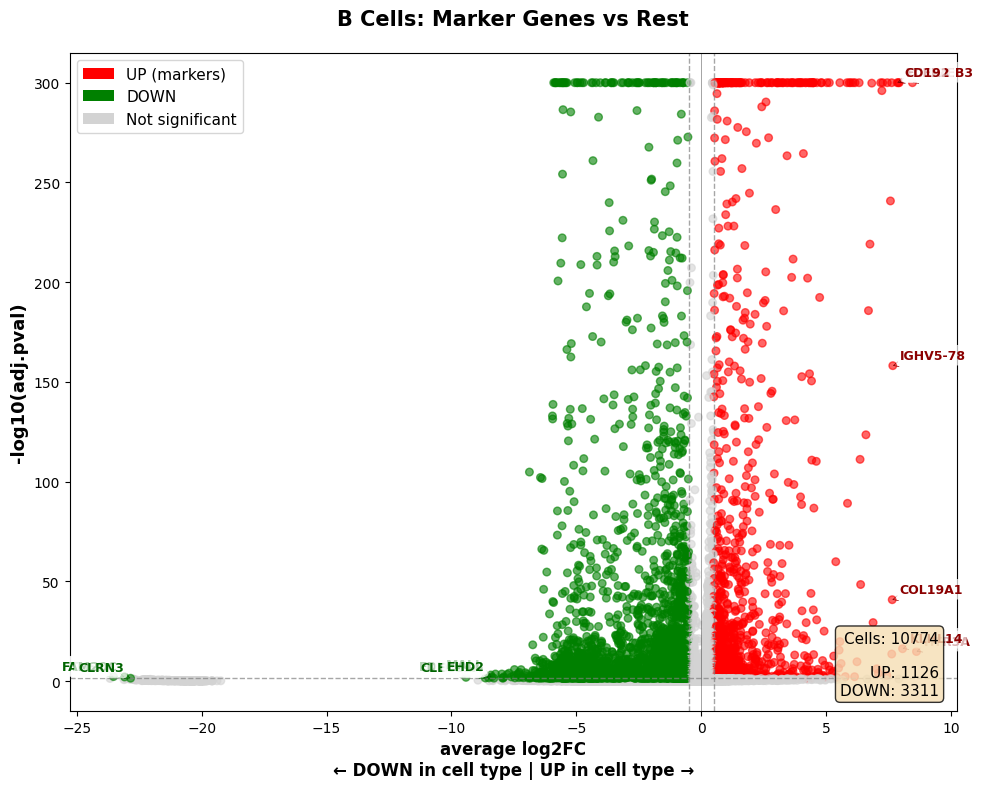

  ✅ Saved volcano plot

Plotting Spp1+...


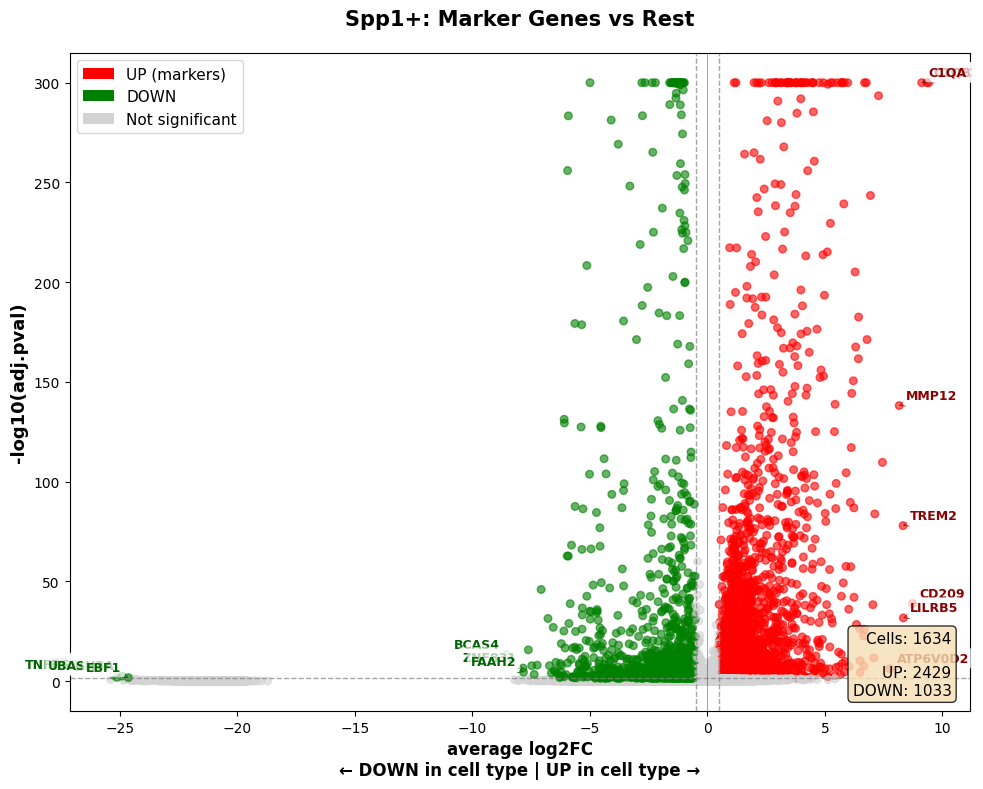

  ✅ Saved volcano plot

Plotting Mast cells...


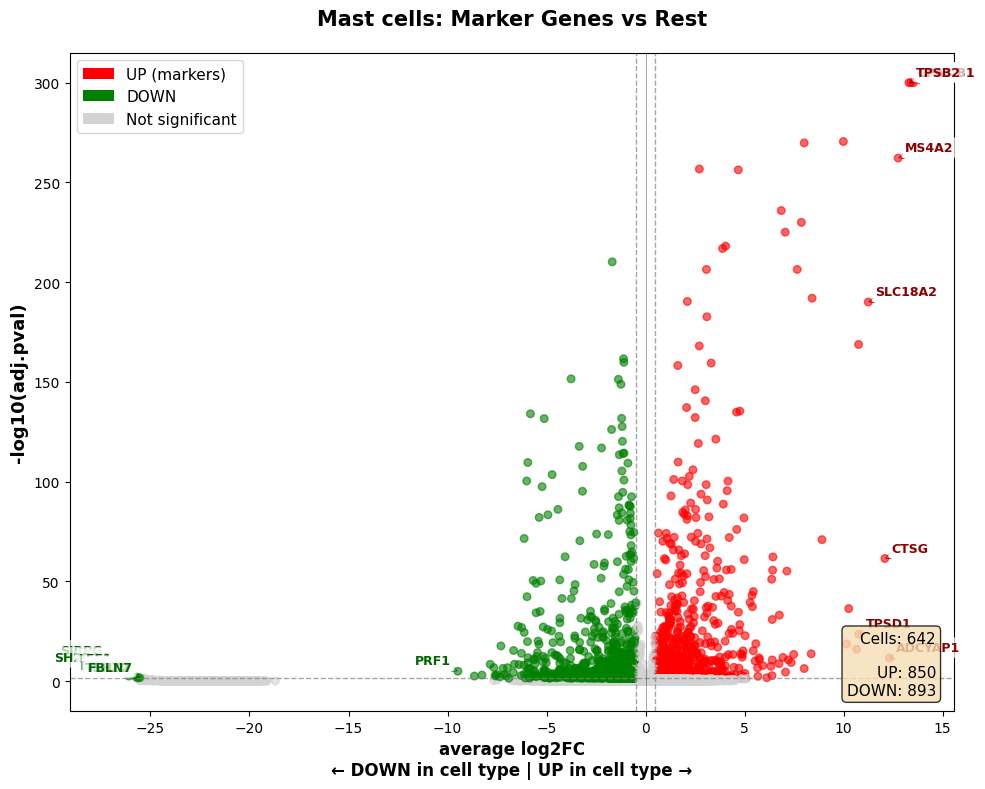

  ✅ Saved volcano plot

Plotting Stromal 2...


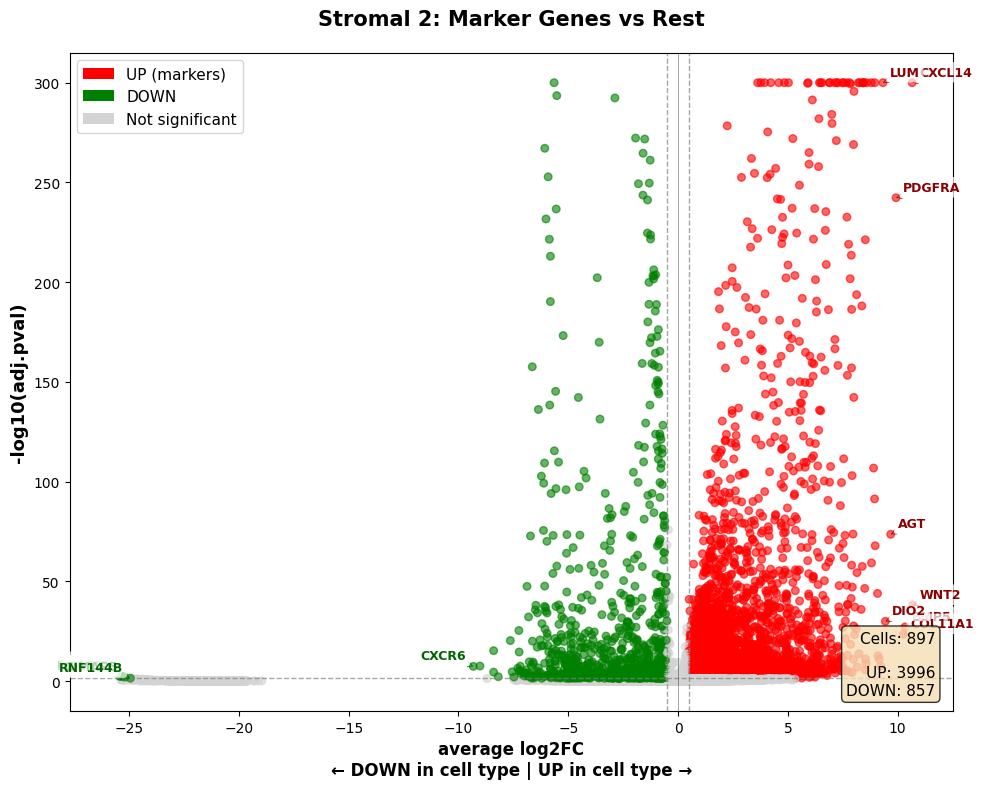

  ✅ Saved volcano plot

Plotting CMS2...


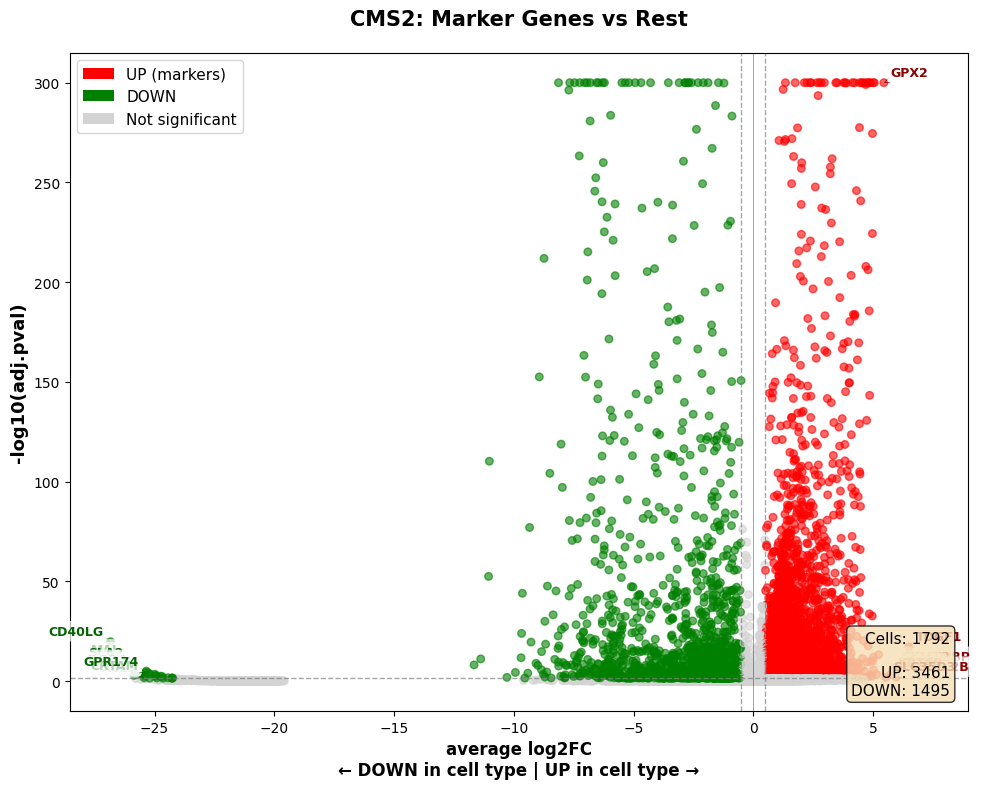

  ✅ Saved volcano plot

Plotting Regulatory T Cells...


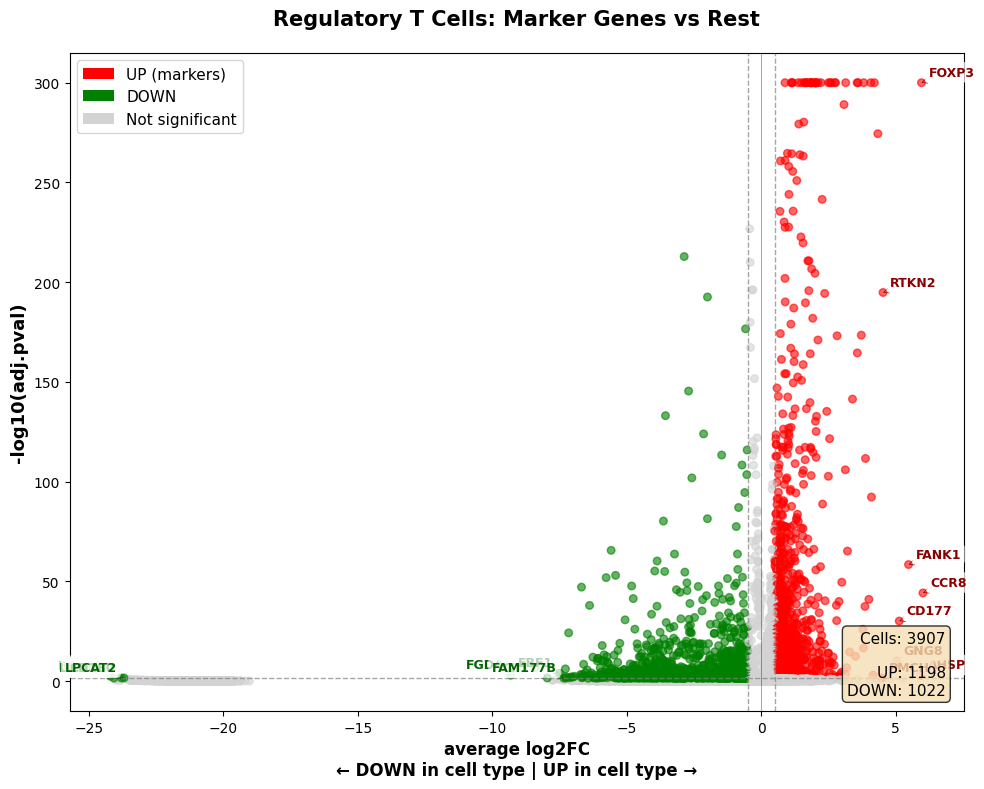

  ✅ Saved volcano plot

Plotting Pericytes...


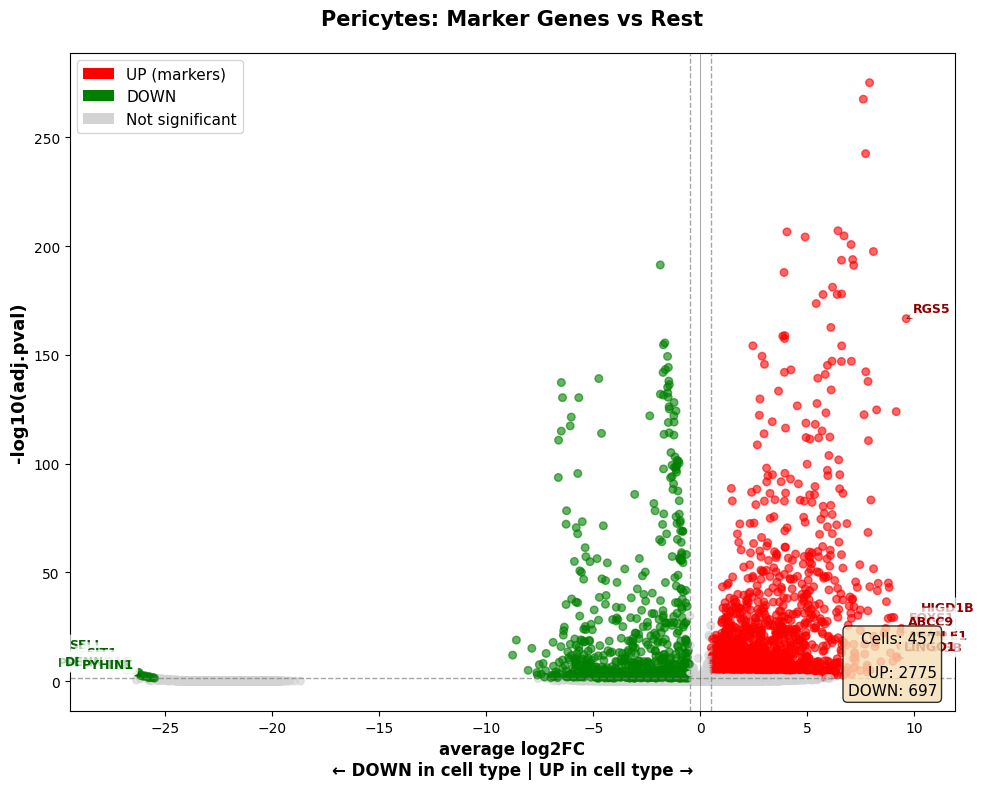

  ✅ Saved volcano plot

Plotting Dendritic cells...


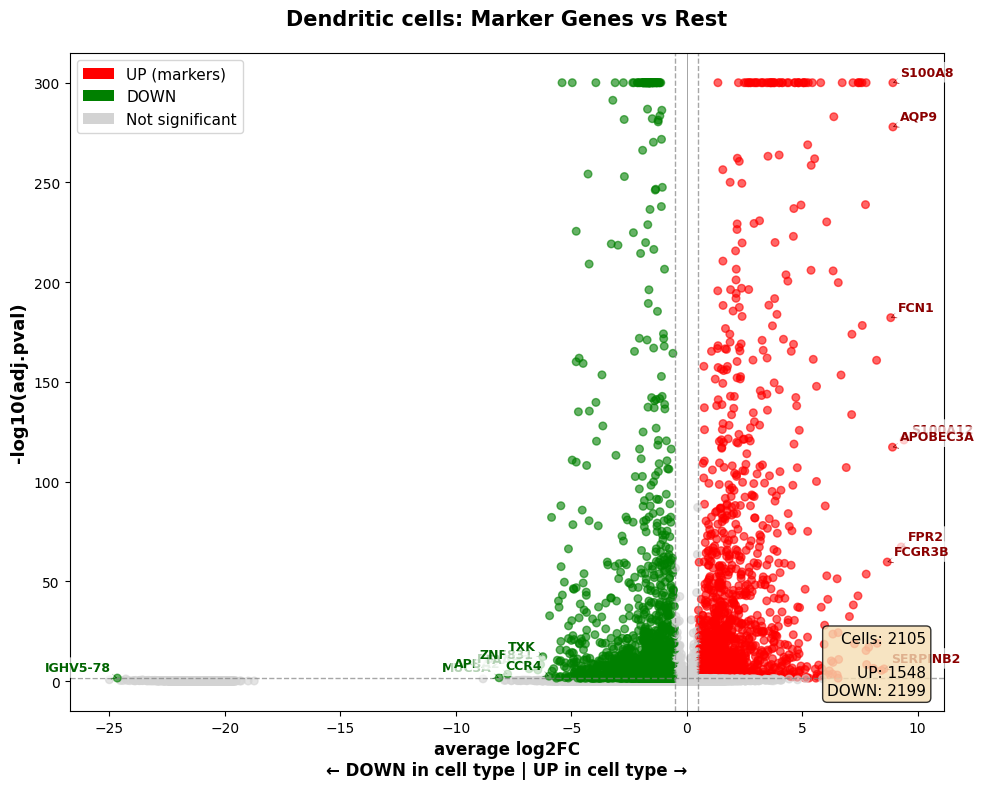

  ✅ Saved volcano plot

Plotting Gamma delta T cells...


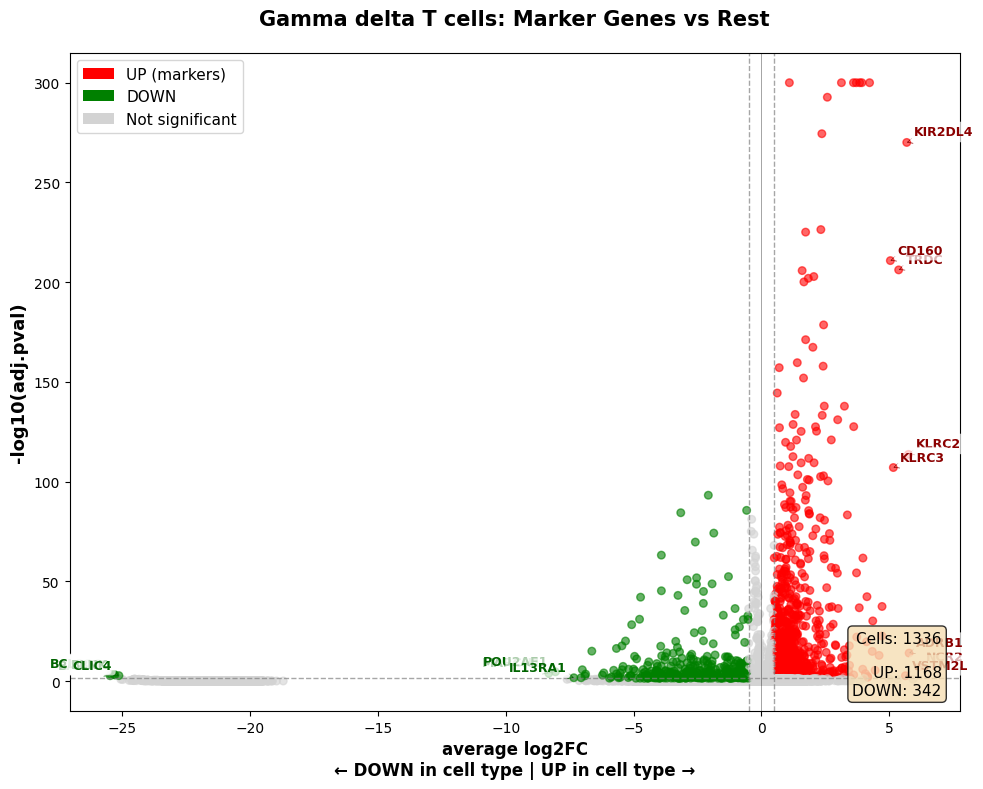

  ✅ Saved volcano plot

Plotting Helper 17 T cells...


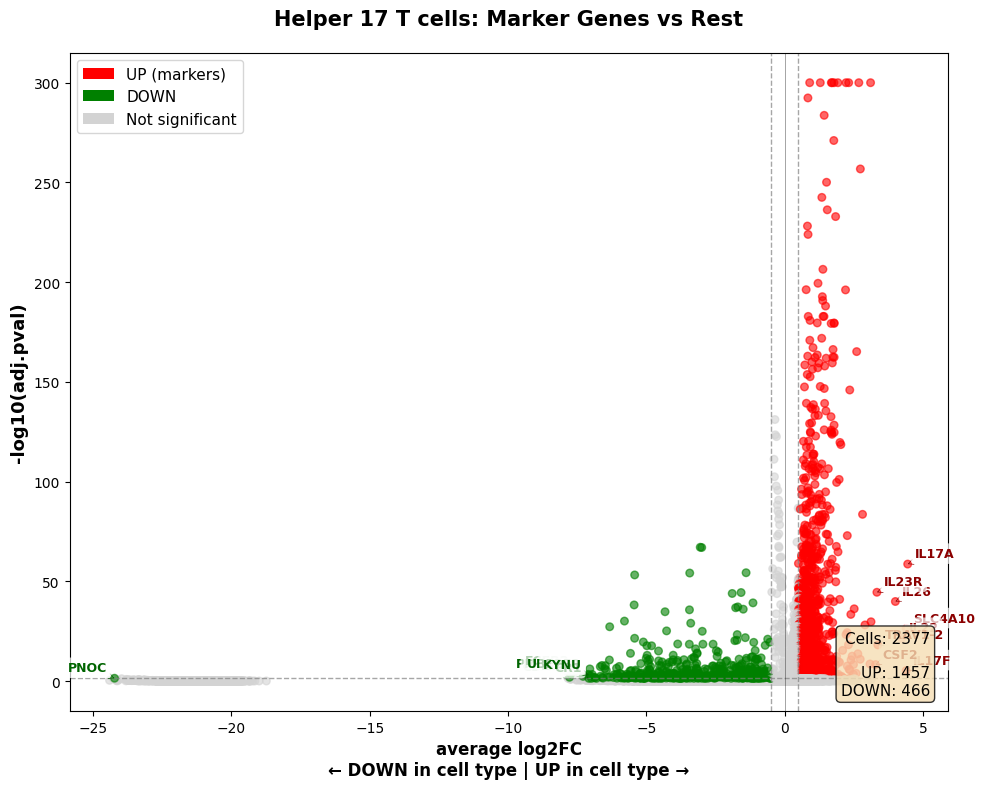

  ✅ Saved volcano plot

Plotting Mature Enterocytes type 2...


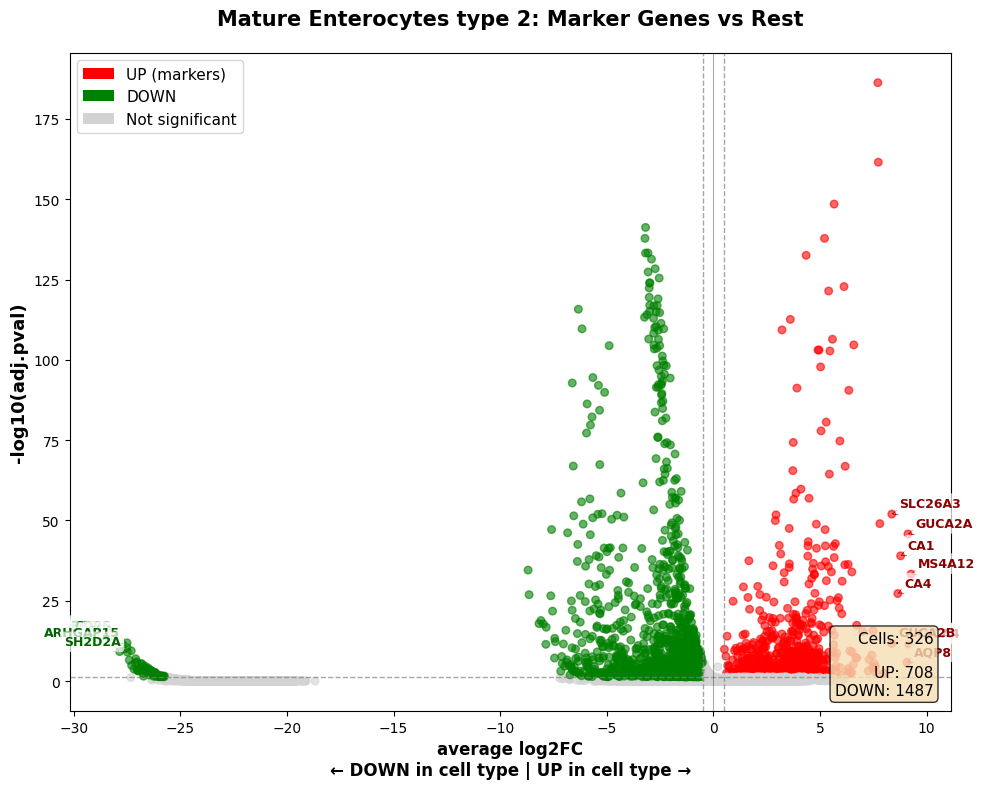

  ✅ Saved volcano plot

Plotting NK cells...


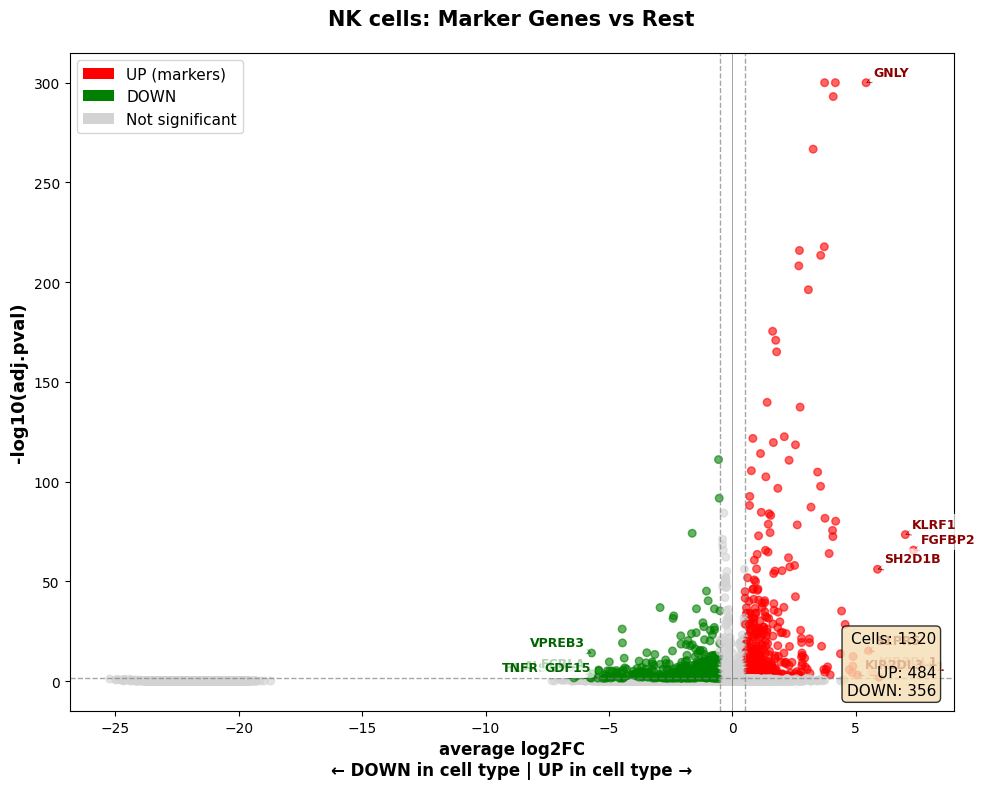

  ✅ Saved volcano plot

Plotting Plasma Cells...


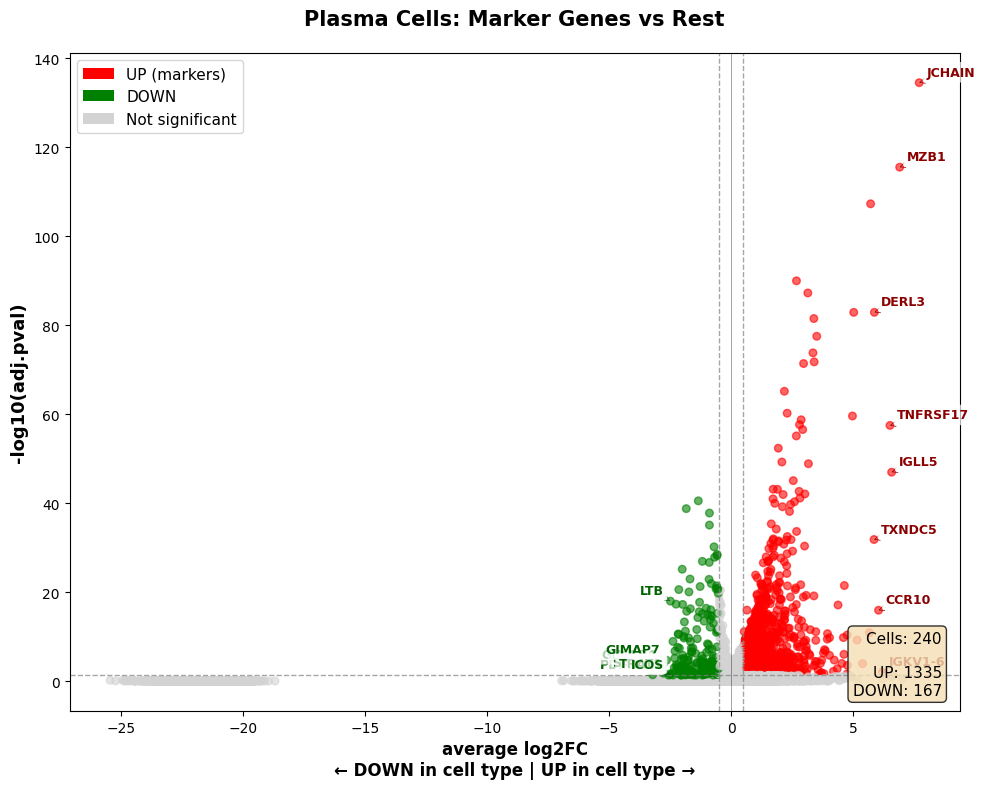

  ✅ Saved volcano plot

Plotting Stromal 3...


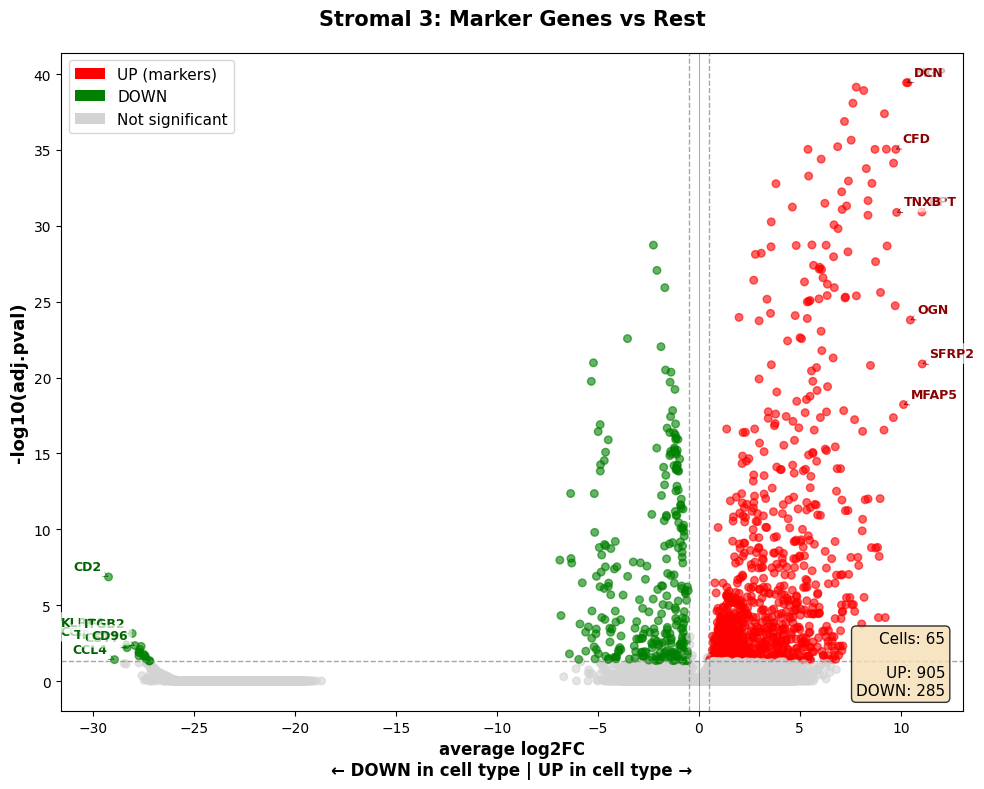

  ✅ Saved volcano plot

Plotting Plasmacytoid Dendritic Cells...


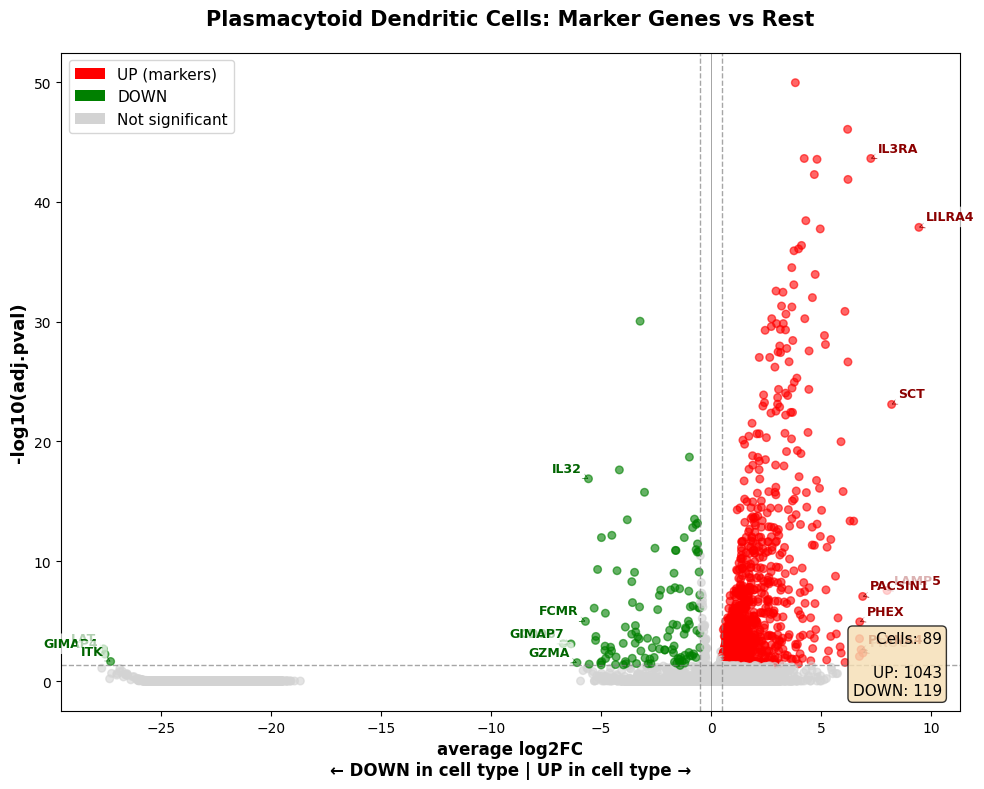

  ✅ Saved volcano plot

Plotting Follicular helper T cells...


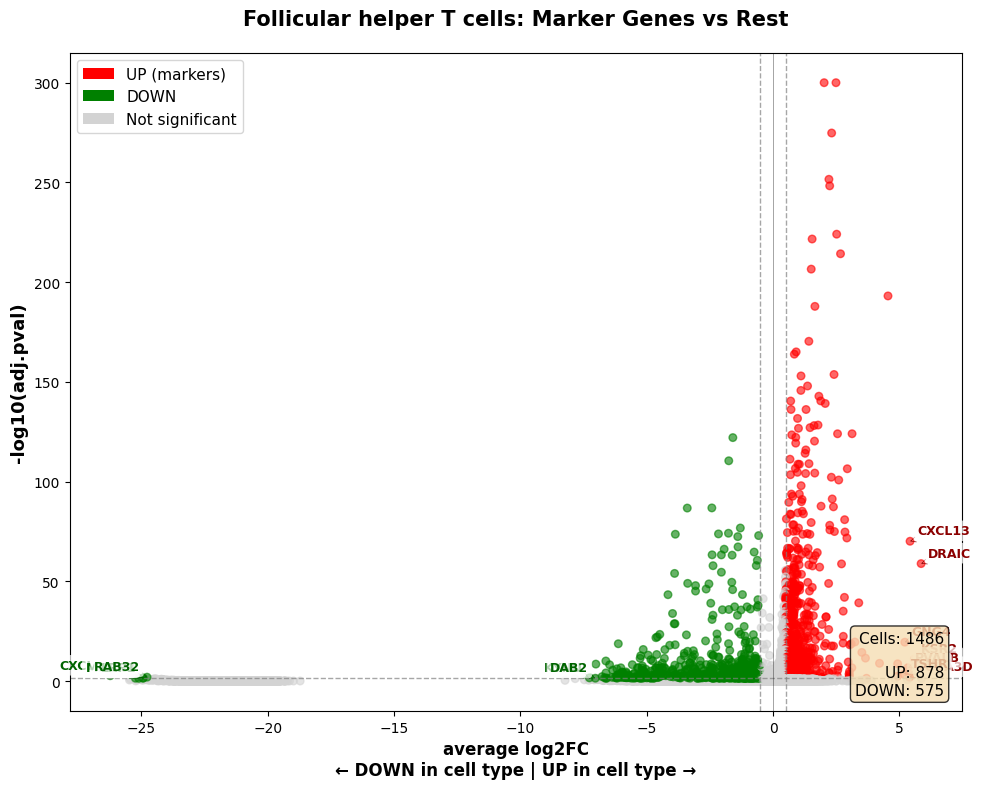

  ✅ Saved volcano plot

Plotting Enteric glia cells...


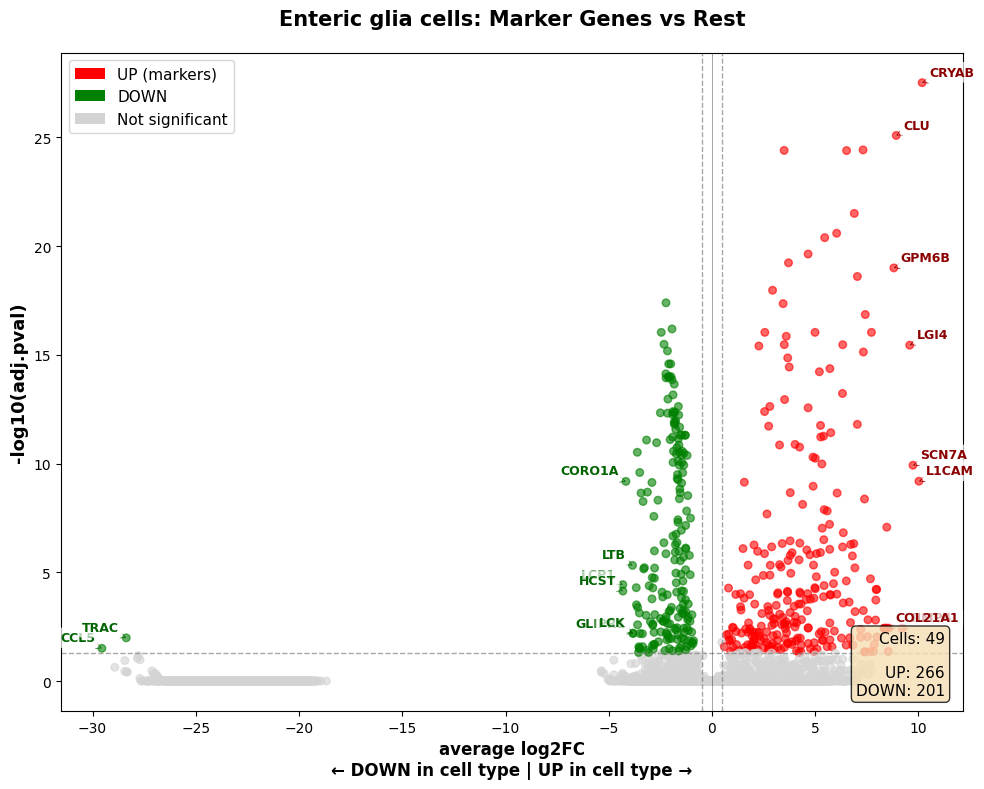

  ✅ Saved volcano plot

✅ All volcano plots completed!


In [14]:


print("Creating volcano plots for each cell type...")

for cell_type in all_degs['Cell_Type'].unique():
    print(f"\nPlotting {cell_type}...")
    
    # Get DEGs for this cell type
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    if len(ct_degs) == 0:
        continue
    
    # Calculate -log10(pval)
    ct_degs['-log10_pval'] = -np.log10(ct_degs['pvals_adj'] + 1e-300)
    
    # Color by significance
    colors = []
    for _, row in ct_degs.iterrows():
        if row['pvals_adj'] < 0.05 and abs(row['logfoldchanges']) > 0.5:
            if row['logfoldchanges'] > 0:
                colors.append('red')  # UP in this cell type
            else:
                colors.append('green')  # DOWN in this cell type
        else:
            colors.append('lightgray')
    
    # Create volcano plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.scatter(
        ct_degs['logfoldchanges'],
        ct_degs['-log10_pval'],
        c=colors,
        alpha=0.6,
        s=30
    )
    
    # Label top genes
    sig_genes = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (abs(ct_degs['logfoldchanges']) > 0.5)
    ]
    
    # Top UP genes
    up_genes = sig_genes[sig_genes['logfoldchanges'] > 0].nlargest(8, 'logfoldchanges')
    # Top DOWN genes
    down_genes = sig_genes[sig_genes['logfoldchanges'] < 0].nsmallest(8, 'logfoldchanges')
    
    # Annotate UP genes
    for _, gene in up_genes.iterrows():
        ax.annotate(
            gene['names'],
            xy=(gene['logfoldchanges'], gene['-log10_pval']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold',
            color='darkred',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=0.5)
        )
    
    # Annotate DOWN genes
    for _, gene in down_genes.iterrows():
        ax.annotate(
            gene['names'],
            xy=(gene['logfoldchanges'], gene['-log10_pval']),
            xytext=(-5, 5),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold',
            color='darkgreen',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=0.5),
            ha='right'
        )
    
    # Formatting
    ax.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    ax.set_xlabel('average log2FC\n← DOWN in cell type | UP in cell type →', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('-log10(adj.pval)', fontsize=13, fontweight='bold')
    ax.set_title(f'{cell_type}: Marker Genes vs Rest', fontsize=15, fontweight='bold', pad=20)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='UP (markers)'),
        Patch(facecolor='green', label='DOWN'),
        Patch(facecolor='lightgray', label='Not significant')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True)
    
    # Summary stats
    n_up = sum([1 for c in colors if c == 'red'])
    n_down = sum([1 for c in colors if c == 'green'])
    n_cells = ct_degs['n_cells'].iloc[0]
    
    textstr = f'Cells: {n_cells}\n\nUP: {n_up}\nDOWN: {n_down}'
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'volcano_marker_{cell_type.replace(" ", "_").replace("+", "plus").replace("/", "_")}.pdf', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✅ Saved volcano plot")

print("\n✅ All volcano plots completed!")

Creating heatmaps for each cell type...

Processing: CD4+ T Cells
Significant DEGs: 4734
Selected: 25 UP, 25 DOWN


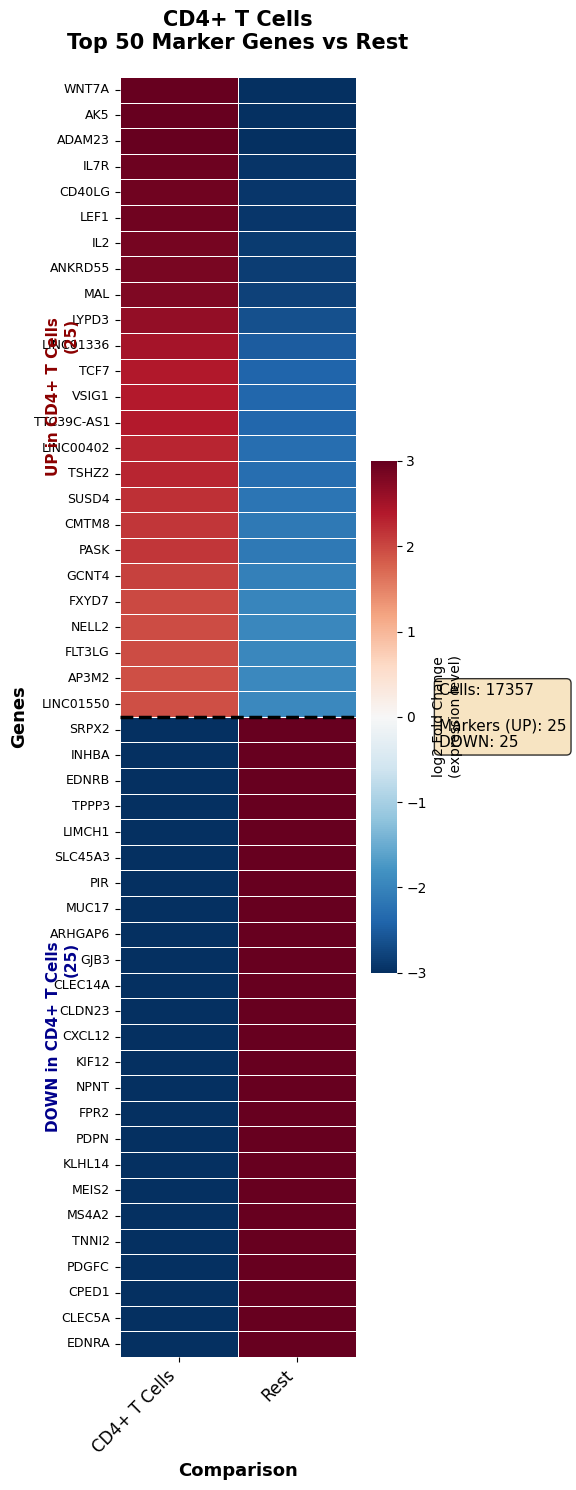

  ✅ Saved heatmap

Processing: CMS3
Significant DEGs: 6275
Selected: 25 UP, 25 DOWN


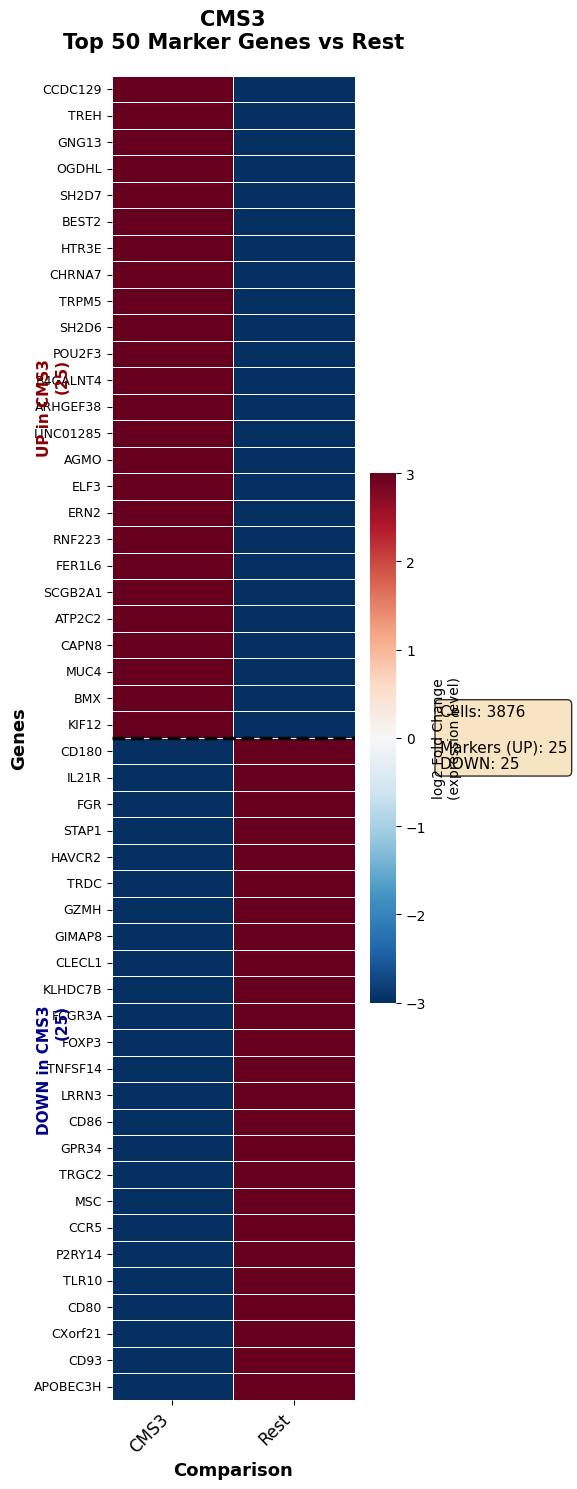

  ✅ Saved heatmap

Processing: Tip-like ECs
Significant DEGs: 4182
Selected: 25 UP, 25 DOWN


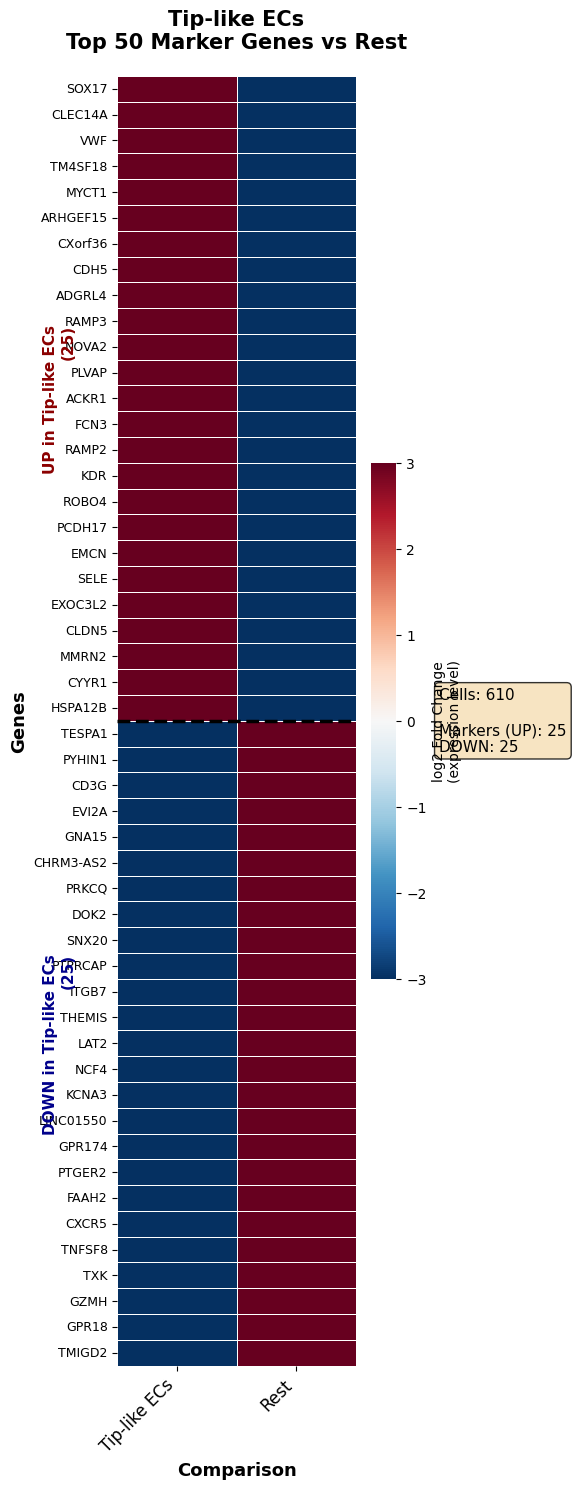

  ✅ Saved heatmap

Processing: CD8+ T cells
Significant DEGs: 2280
Selected: 25 UP, 25 DOWN


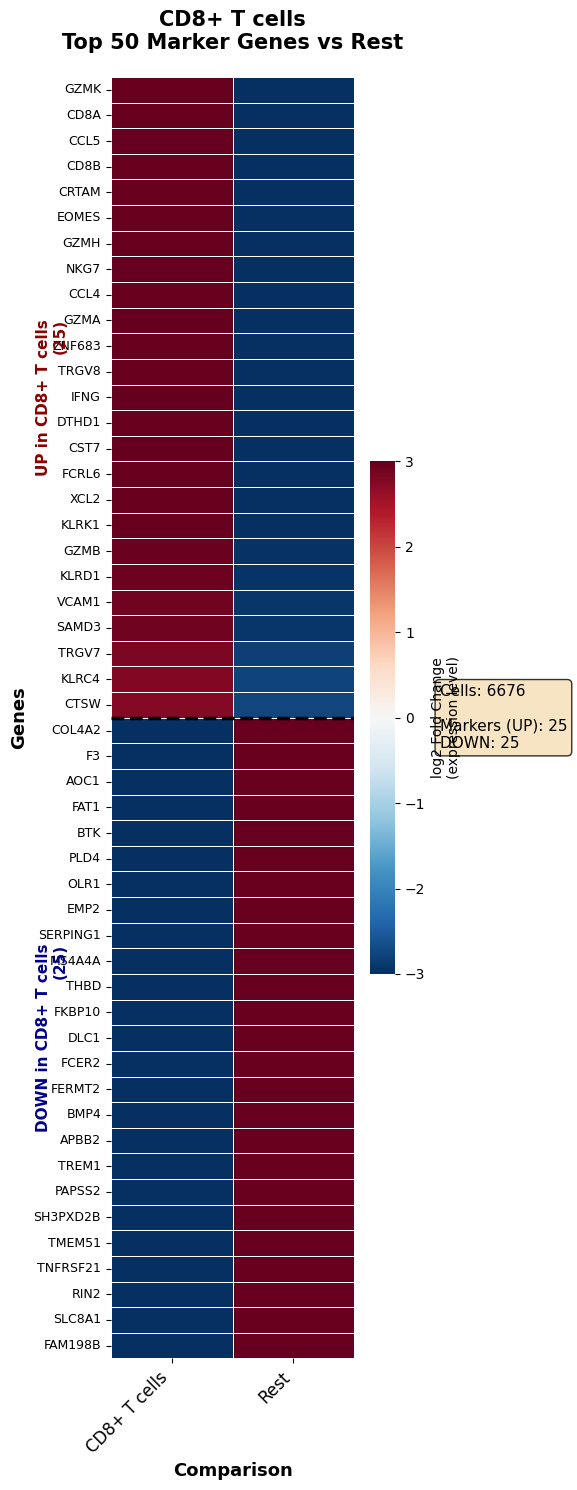

  ✅ Saved heatmap

Processing: B Cells
Significant DEGs: 4437
Selected: 25 UP, 25 DOWN


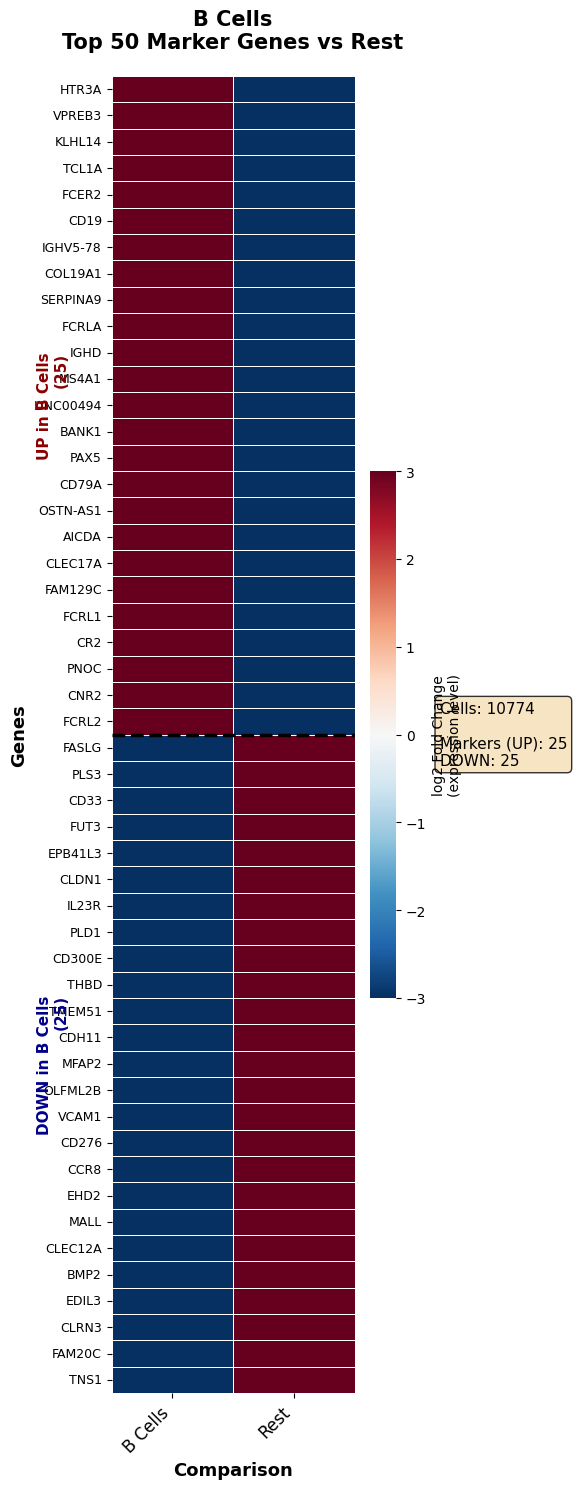

  ✅ Saved heatmap

Processing: Spp1+
Significant DEGs: 3462
Selected: 25 UP, 25 DOWN


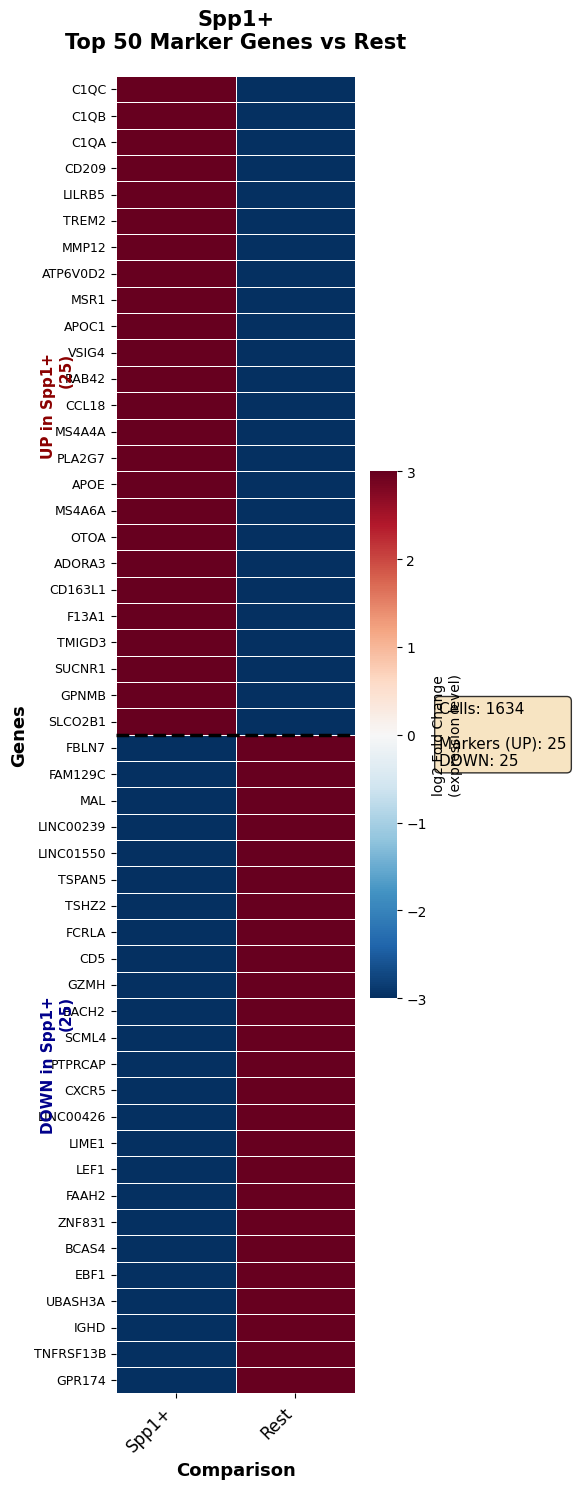

  ✅ Saved heatmap

Processing: Mast cells
Significant DEGs: 1743
Selected: 25 UP, 25 DOWN


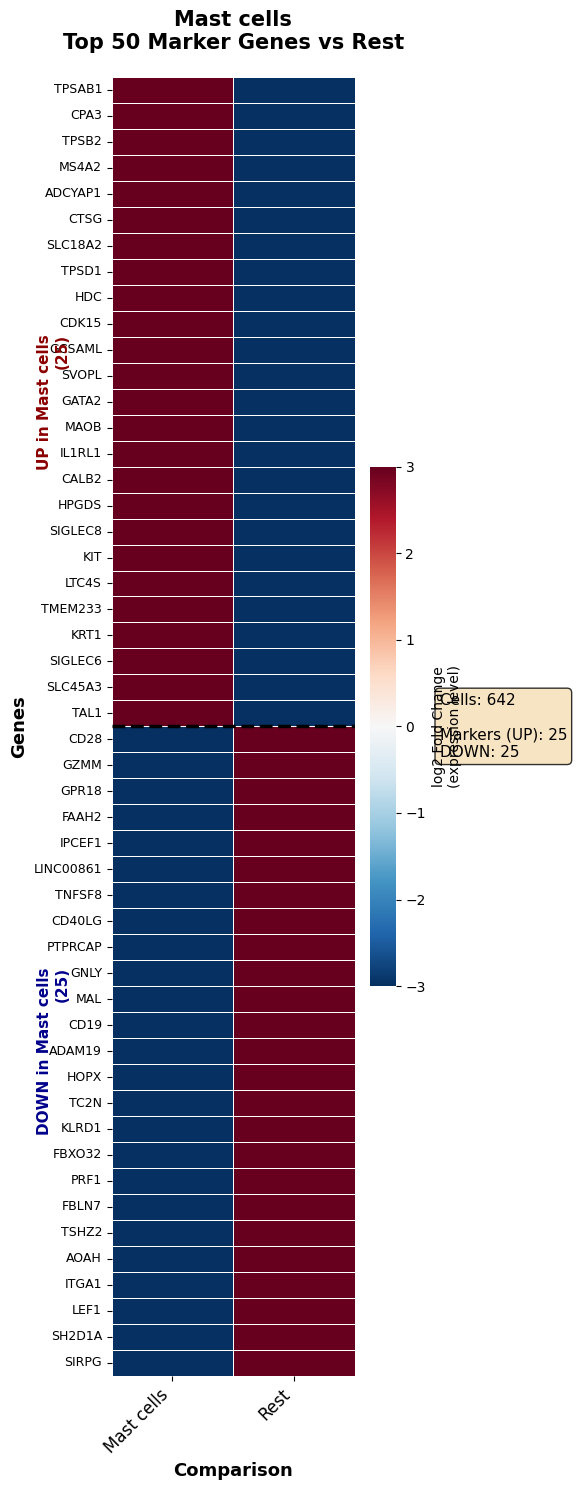

  ✅ Saved heatmap

Processing: Stromal 2
Significant DEGs: 4853
Selected: 25 UP, 25 DOWN


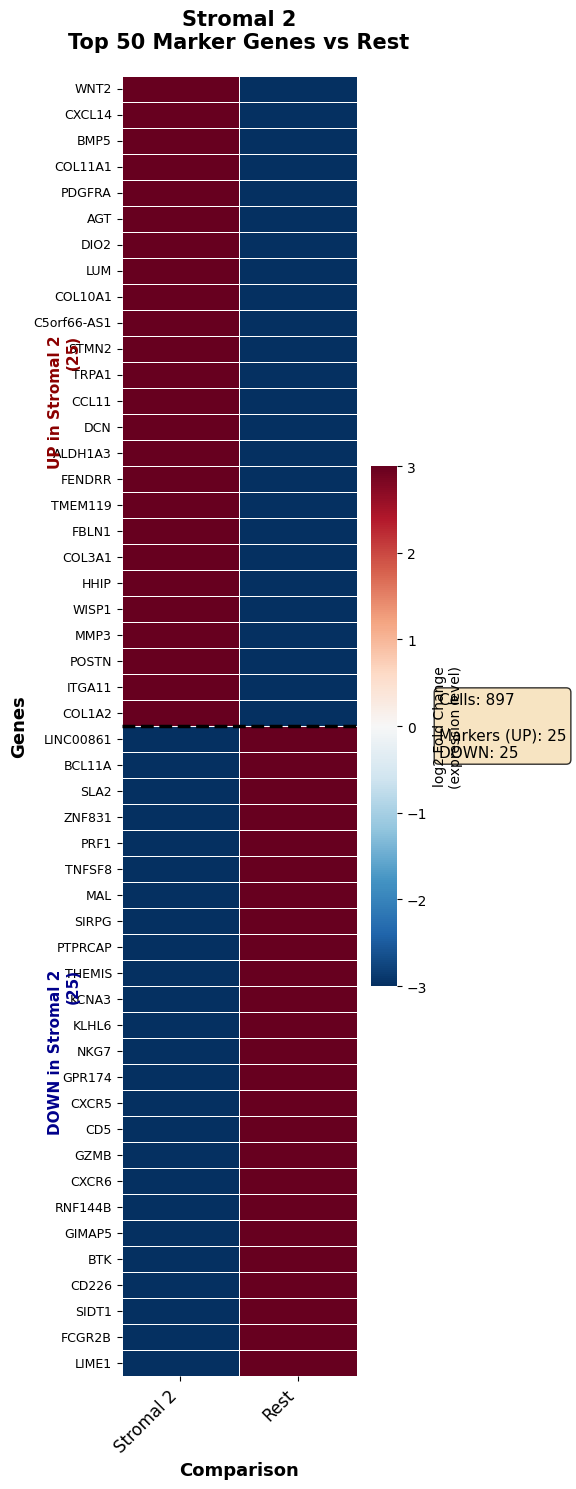

  ✅ Saved heatmap

Processing: CMS2
Significant DEGs: 4956
Selected: 25 UP, 25 DOWN


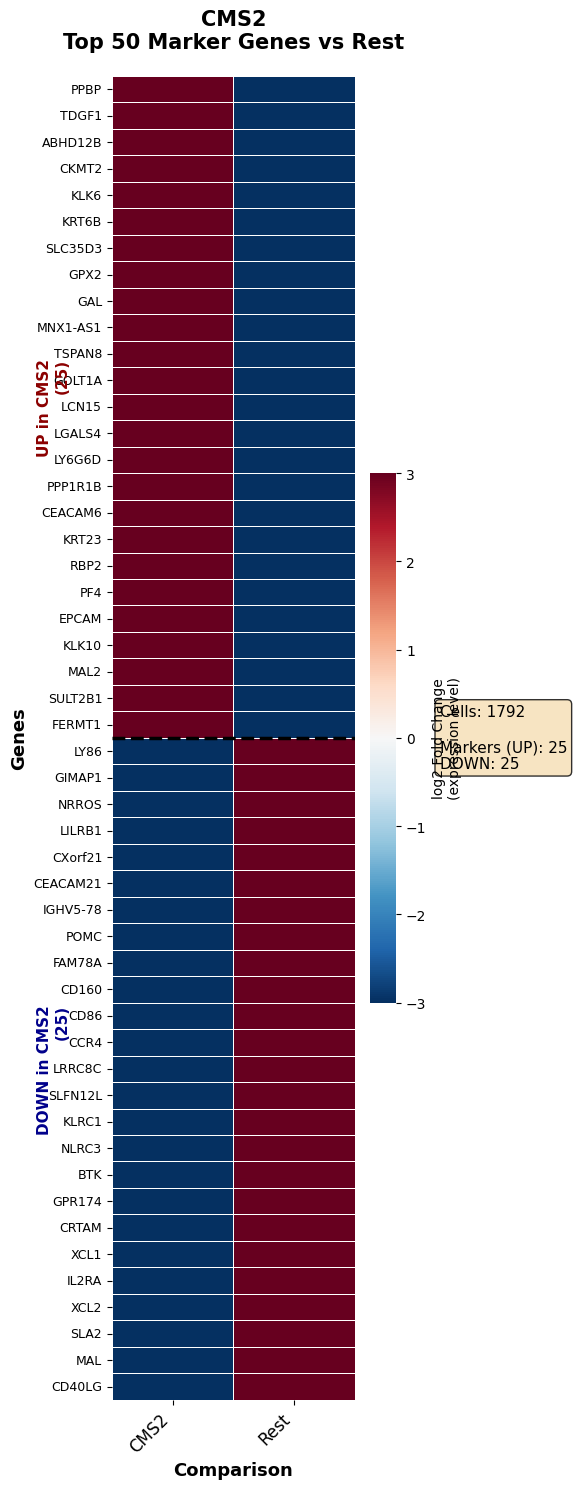

  ✅ Saved heatmap

Processing: Regulatory T Cells
Significant DEGs: 2220
Selected: 25 UP, 25 DOWN


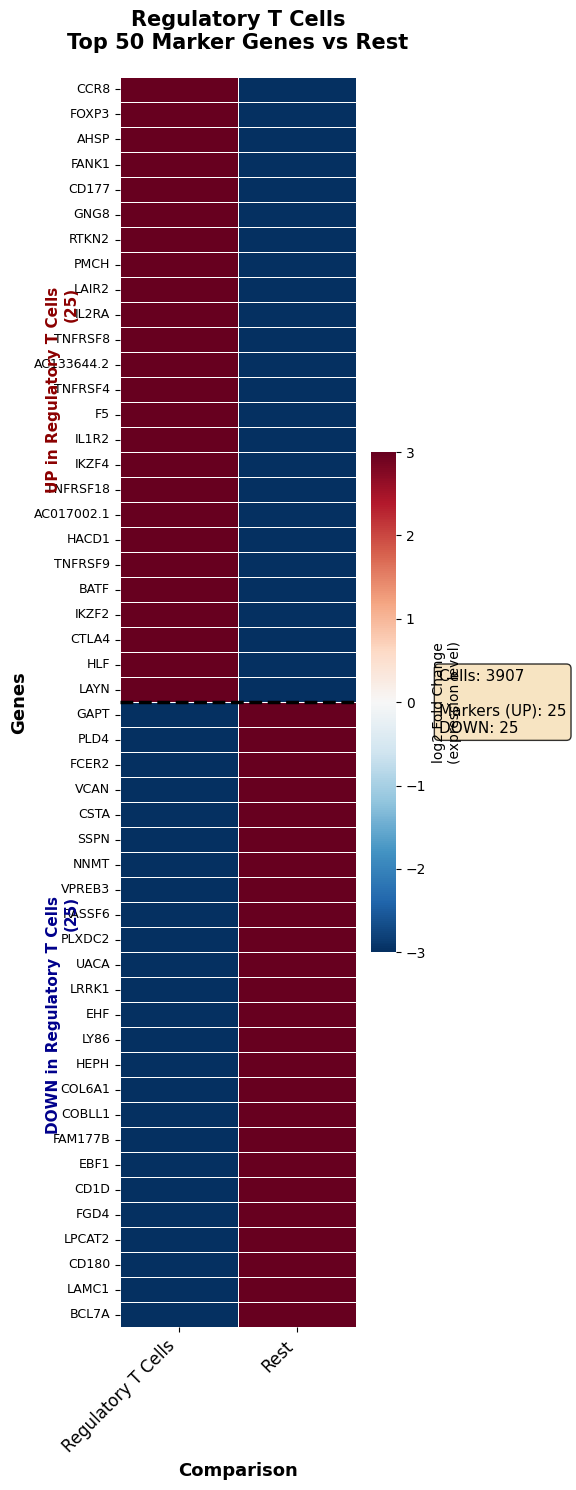

  ✅ Saved heatmap

Processing: Pericytes
Significant DEGs: 3472
Selected: 25 UP, 25 DOWN


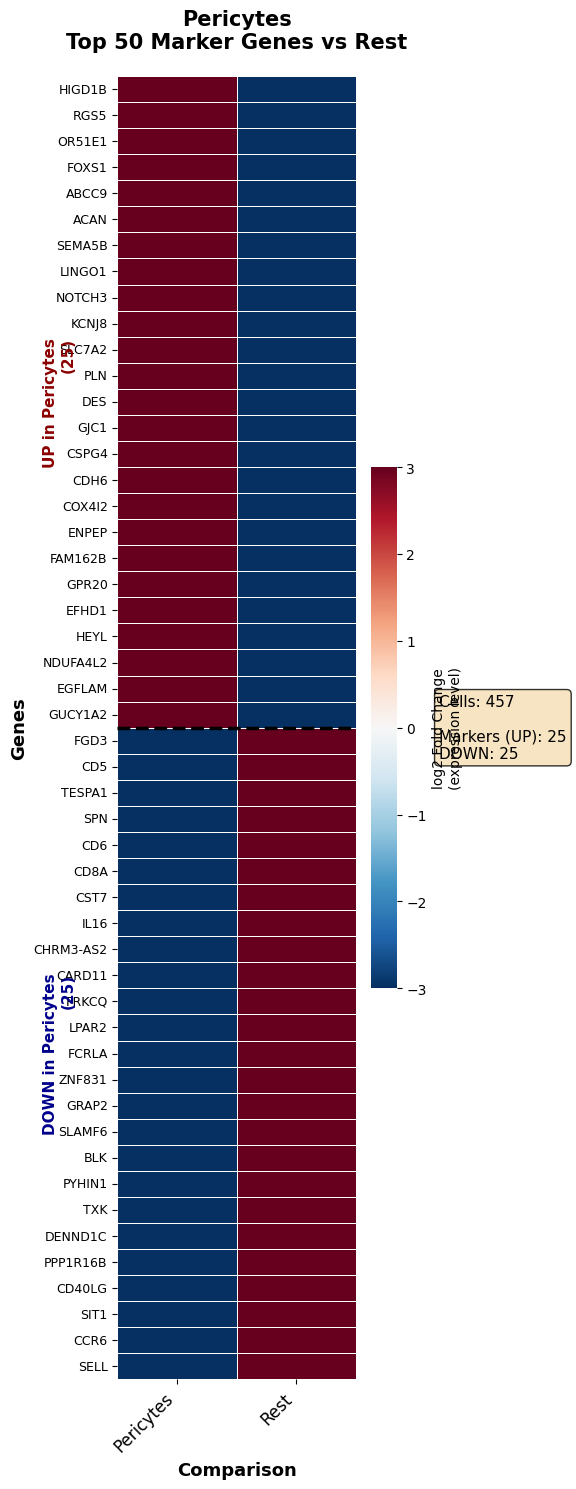

  ✅ Saved heatmap

Processing: Dendritic cells
Significant DEGs: 3747
Selected: 25 UP, 25 DOWN


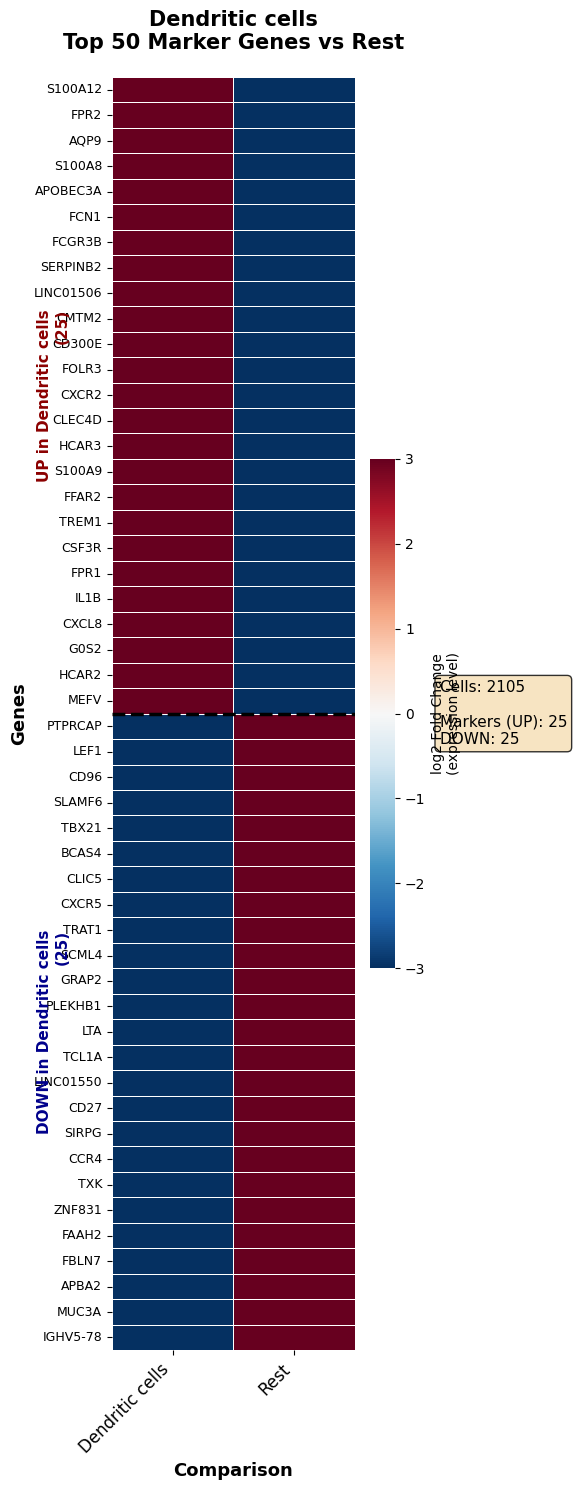

  ✅ Saved heatmap

Processing: Gamma delta T cells
Significant DEGs: 1510
Selected: 25 UP, 25 DOWN


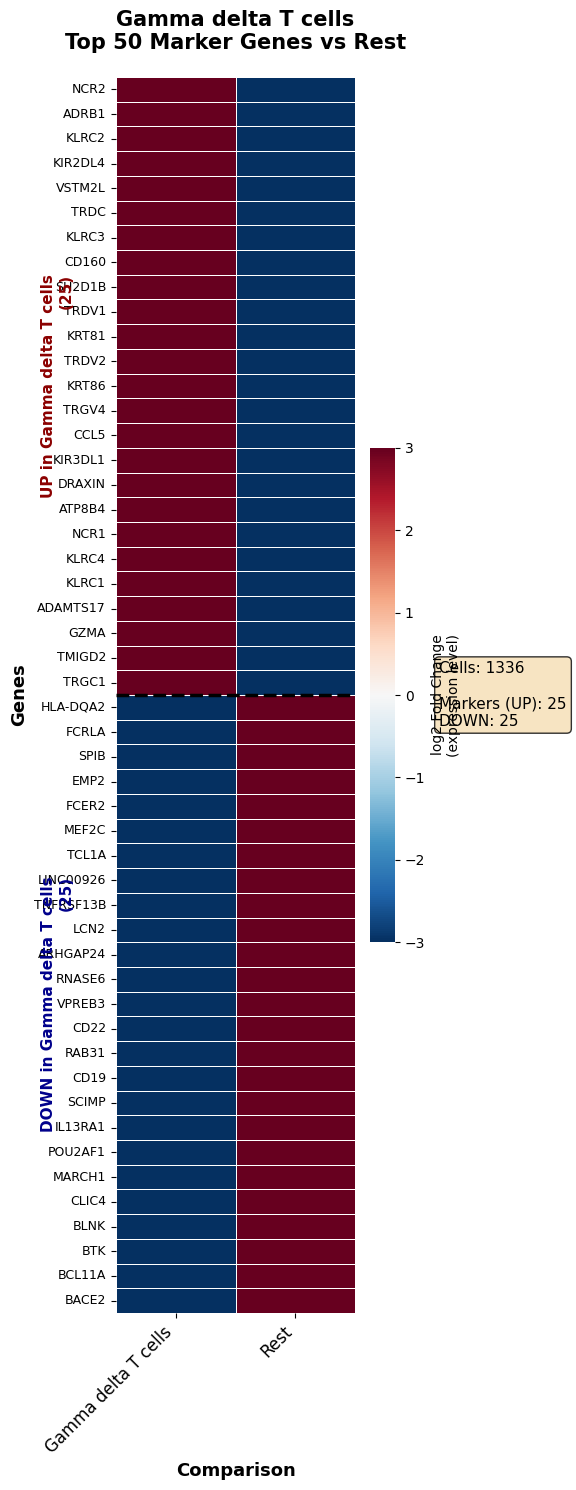

  ✅ Saved heatmap

Processing: Helper 17 T cells
Significant DEGs: 1923
Selected: 25 UP, 25 DOWN


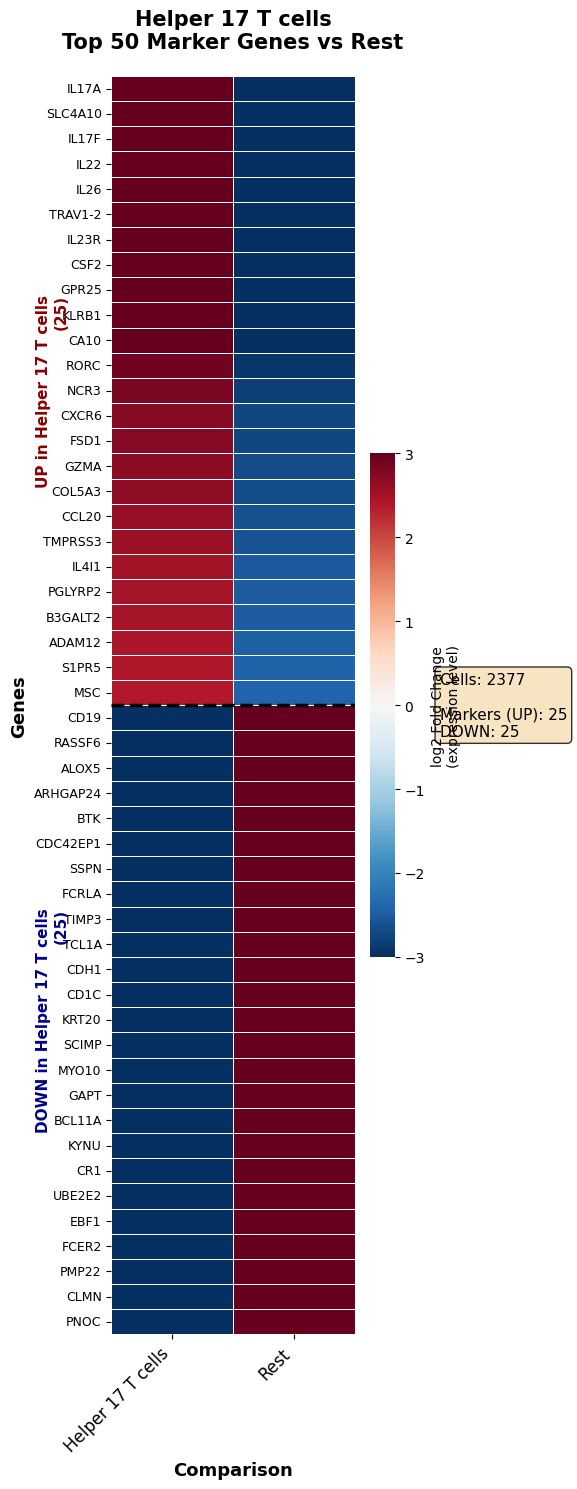

  ✅ Saved heatmap

Processing: Mature Enterocytes type 2
Significant DEGs: 2195
Selected: 25 UP, 25 DOWN


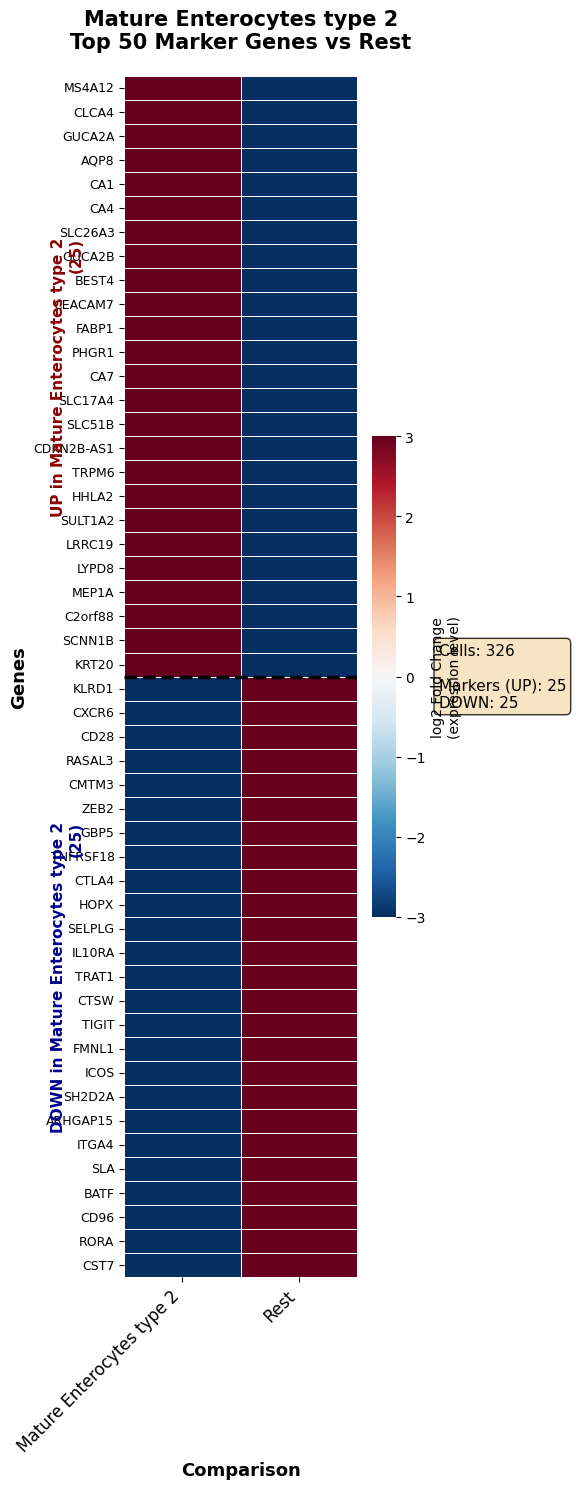

  ✅ Saved heatmap

Processing: NK cells
Significant DEGs: 840
Selected: 25 UP, 25 DOWN


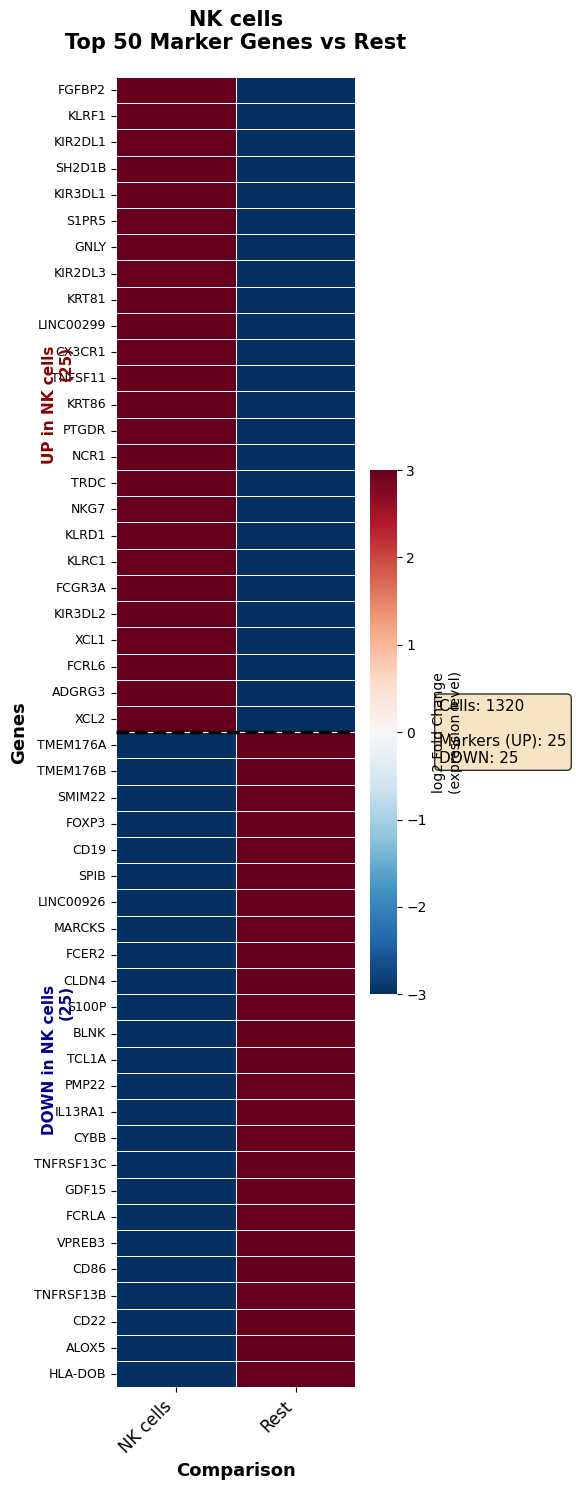

  ✅ Saved heatmap

Processing: Plasma Cells
Significant DEGs: 1502
Selected: 25 UP, 25 DOWN


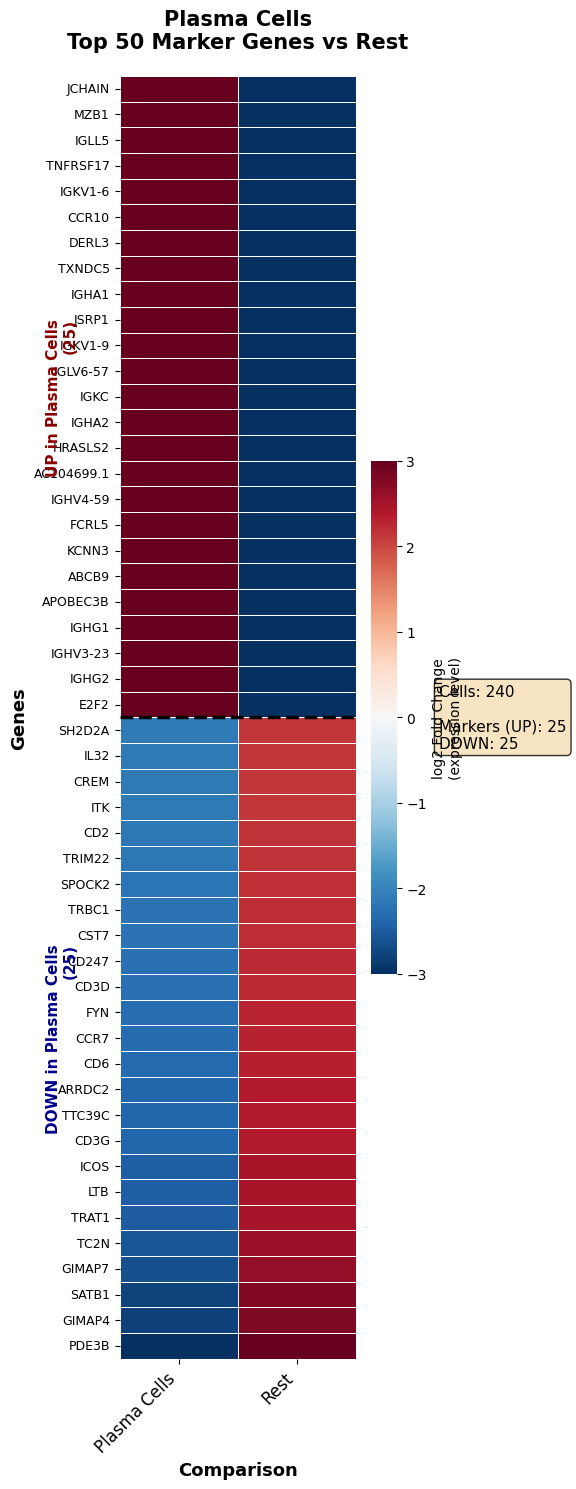

  ✅ Saved heatmap

Processing: Stromal 3
Significant DEGs: 1190
Selected: 25 UP, 25 DOWN


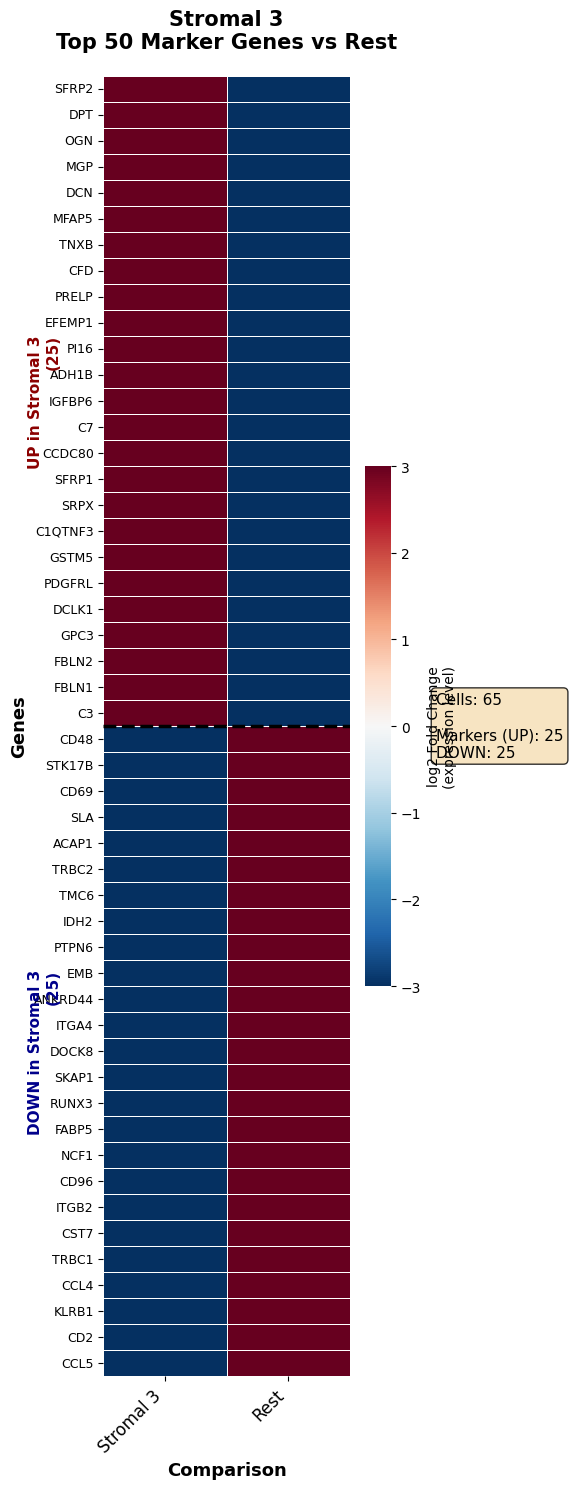

  ✅ Saved heatmap

Processing: Plasmacytoid Dendritic Cells
Significant DEGs: 1162
Selected: 25 UP, 25 DOWN


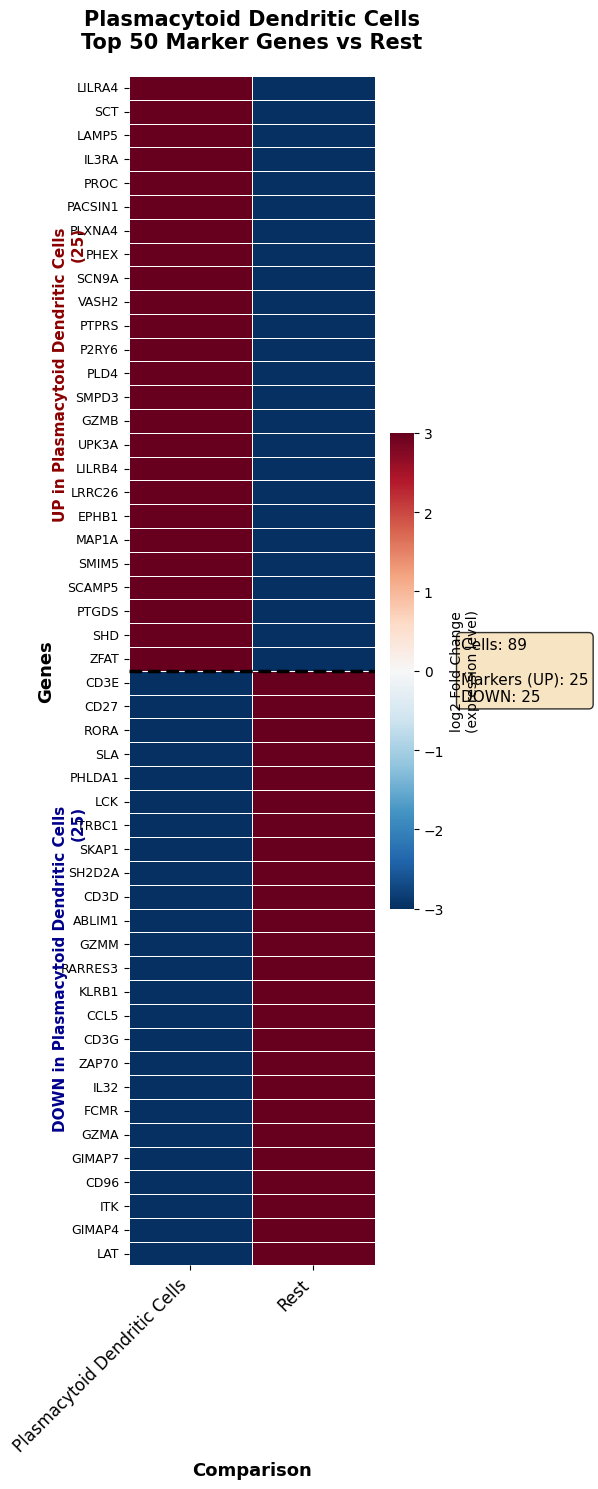

  ✅ Saved heatmap

Processing: Follicular helper T cells
Significant DEGs: 1453
Selected: 25 UP, 25 DOWN


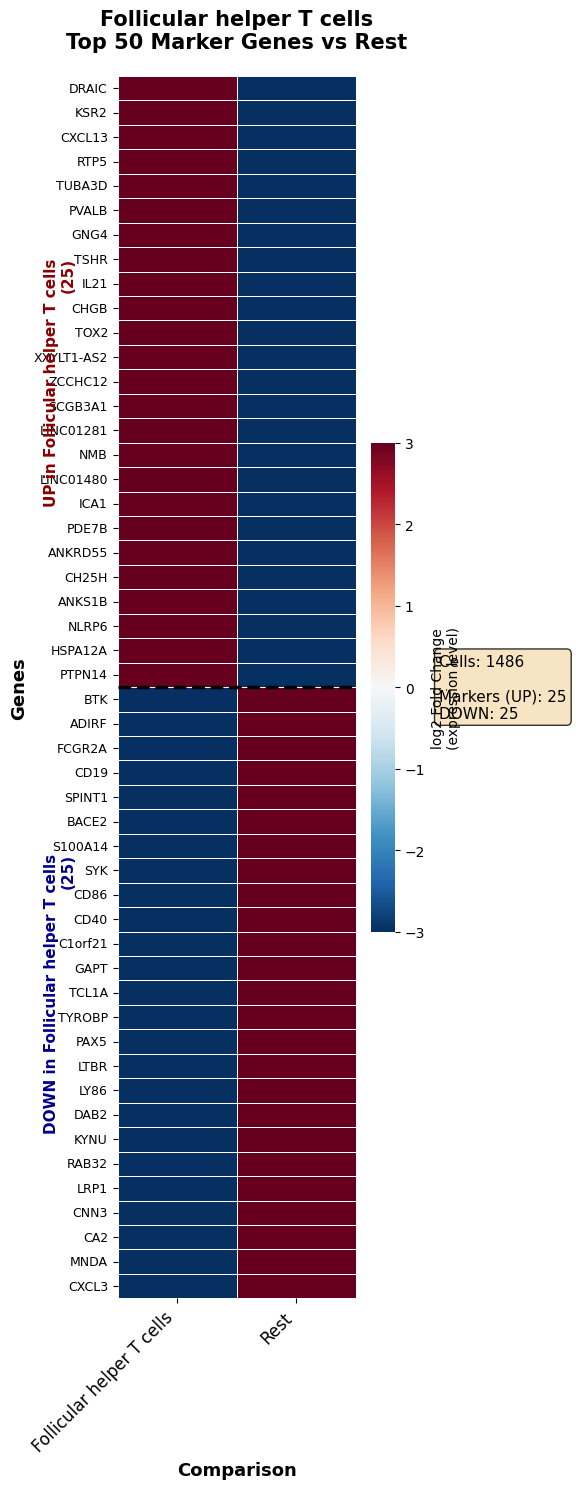

  ✅ Saved heatmap

Processing: Enteric glia cells
Significant DEGs: 467
Selected: 25 UP, 25 DOWN


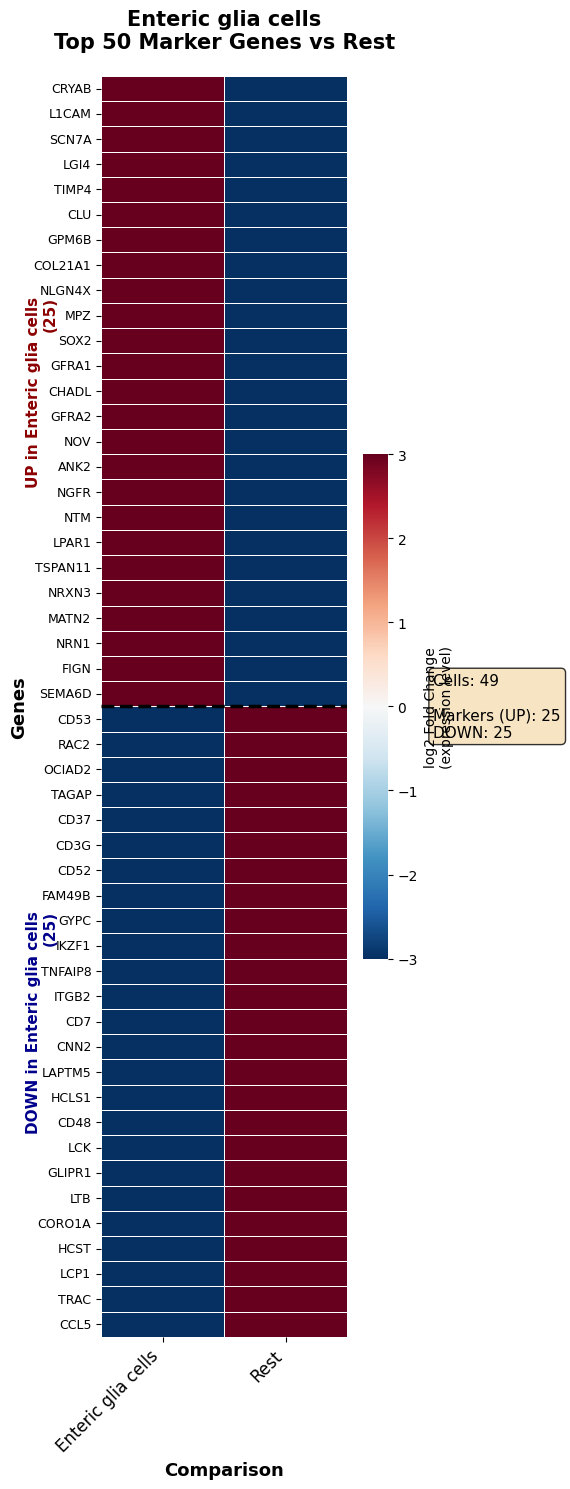

  ✅ Saved heatmap

✅ All heatmaps completed!


In [15]:

# Configuration
N_UP_GENES = 25
N_DOWN_GENES = 25

print("Creating heatmaps for each cell type...")

for cell_type in all_degs['Cell_Type'].unique():
    print(f"\n{'='*60}")
    print(f"Processing: {cell_type}")
    print(f"{'='*60}")
    
    # Get DEGs for this cell type
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    # Filter significant genes
    sig_degs = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (abs(ct_degs['logfoldchanges']) > 0.5)
    ].copy()
    
    print(f"Significant DEGs: {len(sig_degs)}")
    
    if len(sig_degs) == 0:
        print(f"  ❌ No significant DEGs, skipping...")
        continue
    
    # Get top UP and DOWN genes
    up_genes = sig_degs[sig_degs['logfoldchanges'] > 0].nlargest(N_UP_GENES, 'logfoldchanges')
    down_genes = sig_degs[sig_degs['logfoldchanges'] < 0].nsmallest(N_DOWN_GENES, 'logfoldchanges')
    
    print(f"Selected: {len(up_genes)} UP, {len(down_genes)} DOWN")
    
    if len(up_genes) == 0 and len(down_genes) == 0:
        print(f"  ❌ No genes meet criteria, skipping...")
        continue
    
    # Combine genes
    top_genes = pd.concat([up_genes, down_genes]).sort_values('logfoldchanges', ascending=False)
    gene_list = top_genes['names'].tolist()
    
    # Create heatmap data showing expression in this cell type vs rest
    # We'll show log2FC directly
    heatmap_data = pd.DataFrame({
        f'{cell_type}': top_genes.set_index('names')['logfoldchanges'],
        'Rest': -top_genes.set_index('names')['logfoldchanges']  # Flip sign for rest
    })
    heatmap_data = heatmap_data.loc[gene_list]
    
    n_up = len(up_genes)
    n_down = len(down_genes)
    n_cells = ct_degs['n_cells'].iloc[0]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, max(12, len(gene_list) * 0.3)))
    
    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        cmap='RdBu_r',
        center=0,
        vmin=-3,
        vmax=3,
        cbar_kws={'label': 'log2 Fold Change\n(expression level)', 'shrink': 0.4},
        linewidths=0.5,
        linecolor='white',
        yticklabels=True,
        xticklabels=True,
        ax=ax
    )
    
    # Formatting
    ax.set_title(f'{cell_type}\nTop {len(gene_list)} Marker Genes vs Rest', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlabel('Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel('Genes', fontsize=13, fontweight='bold')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
    
    # Dividing line
    if n_up > 0 and n_down > 0:
        ax.axhline(y=n_up, color='black', linewidth=2.5, linestyle='--')
        
        ax.text(-0.35, n_up/2, f'UP in {cell_type}\n({n_up})', 
                rotation=90, va='center', ha='right',
                fontsize=11, fontweight='bold', color='darkred')
        ax.text(-0.35, n_up + n_down/2, 
                f'DOWN in {cell_type}\n({n_down})', 
                rotation=90, va='center', ha='right',
                fontsize=11, fontweight='bold', color='darkblue')
    
    # Statistics box
    textstr = f'Cells: {n_cells}\n\nMarkers (UP): {n_up}\nDOWN: {n_down}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(1.35, 0.5, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='center', bbox=props)
    
    plt.tight_layout()
    
    safe_filename = cell_type.replace(" ", "_").replace("+", "plus").replace("/", "_")
    plt.savefig(f'heatmap_marker_{safe_filename}_log2FC.pdf', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✅ Saved heatmap")

print("\n✅ All heatmaps completed!")

Creating combined heatmap for all cell types...


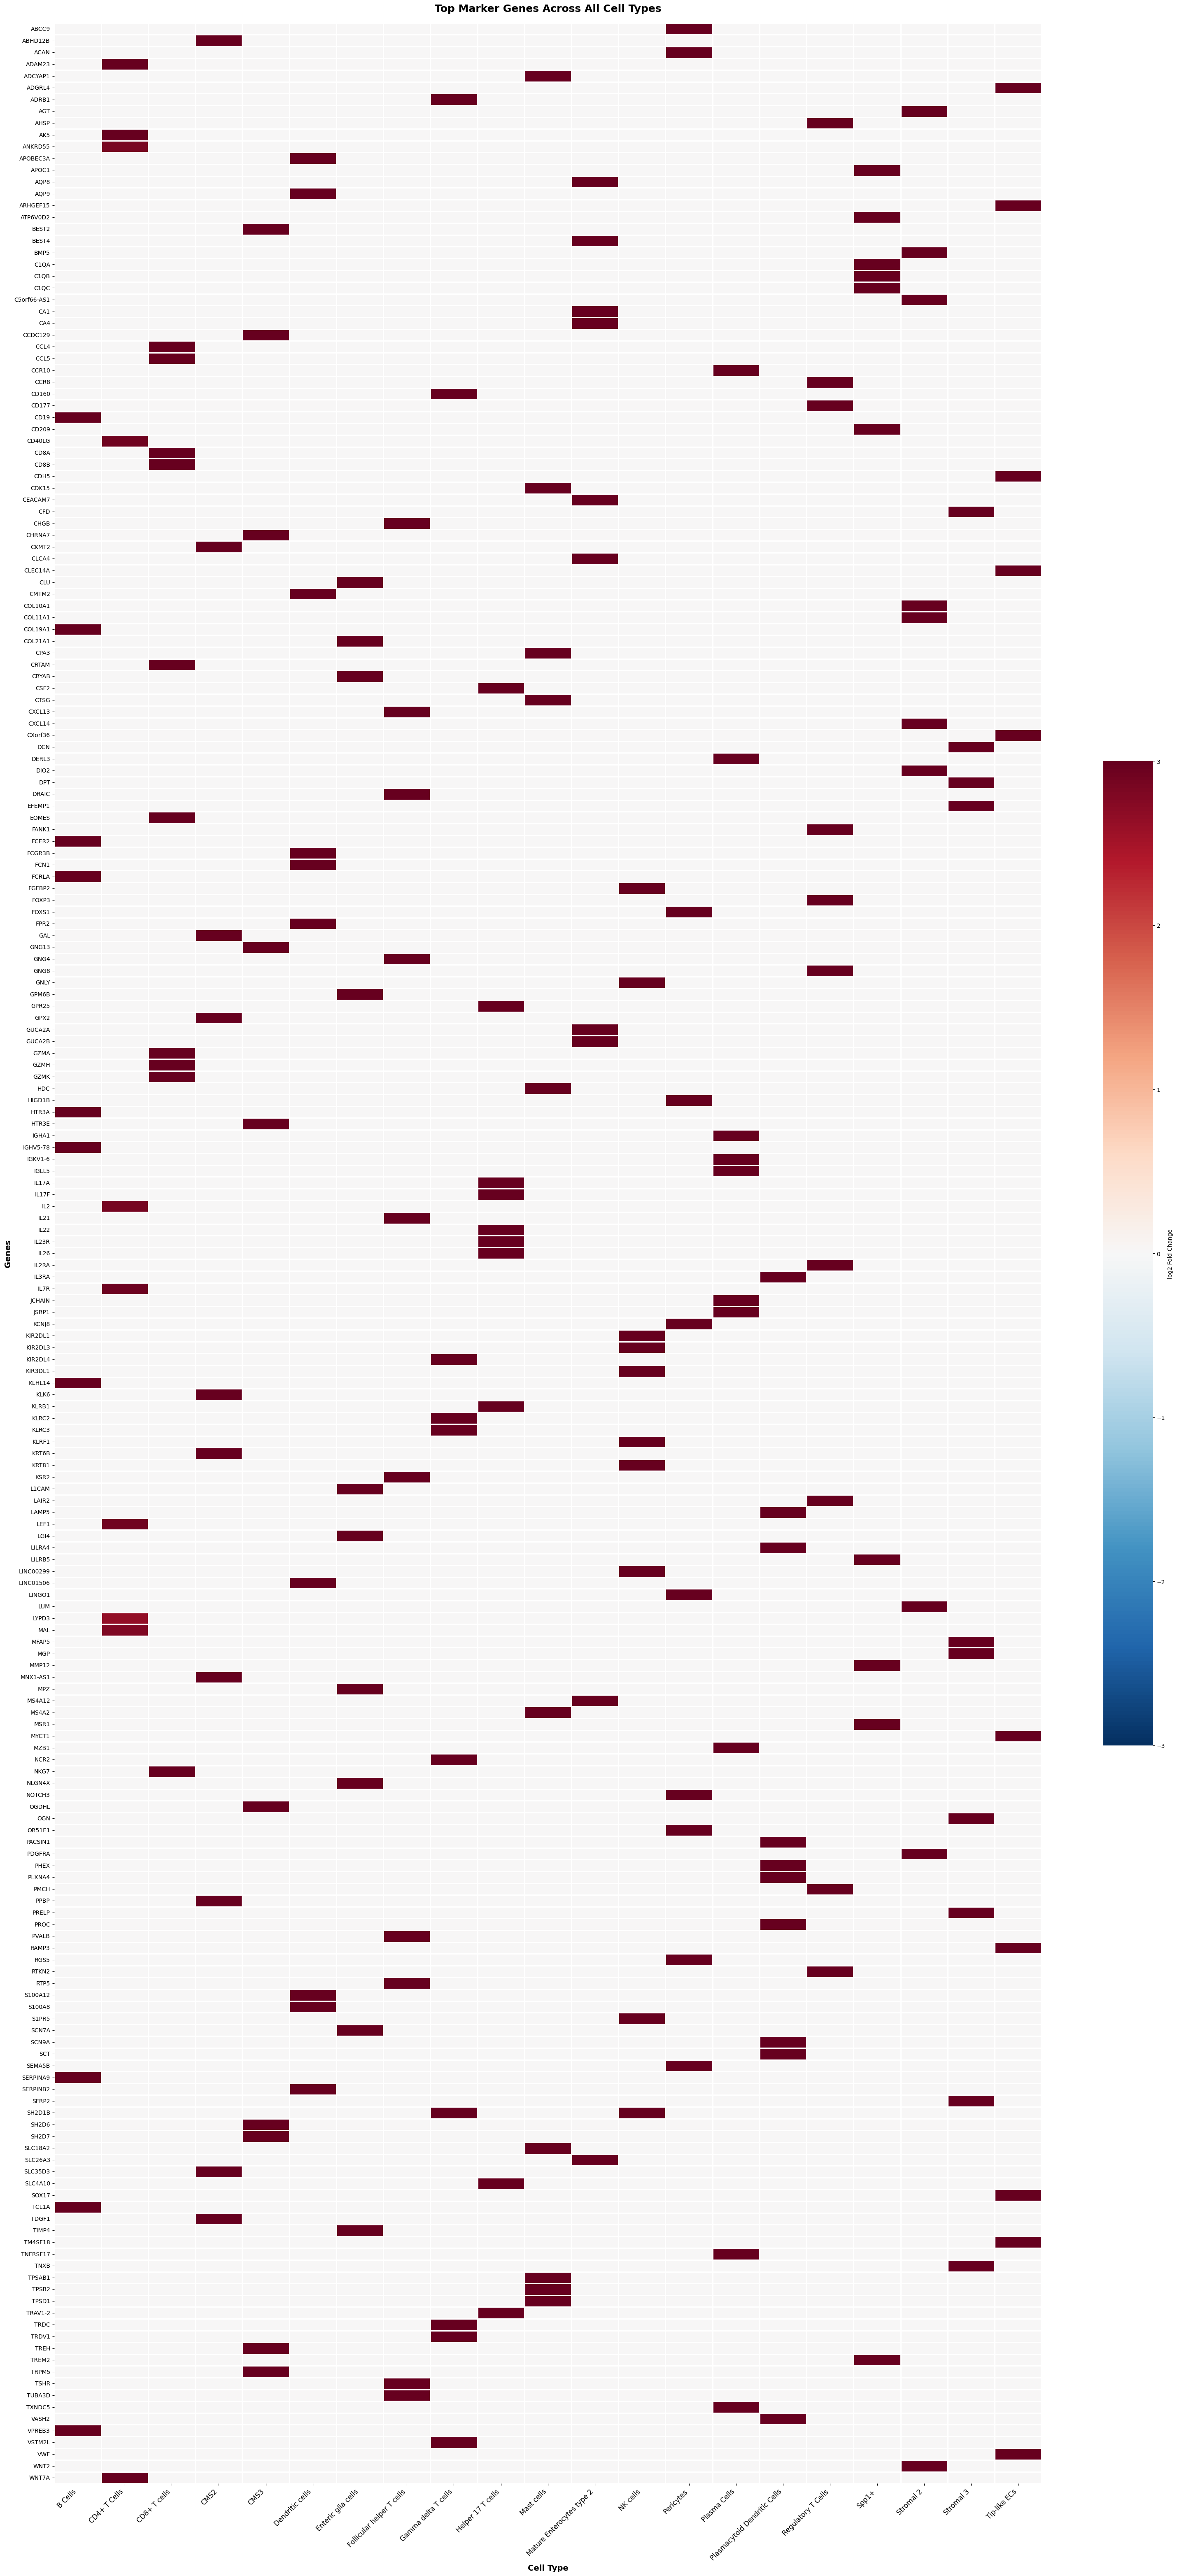

✅ Combined heatmap created with 209 genes


In [16]:

print("Creating combined heatmap for all cell types...")

# Collect top markers for each cell type
heatmap_data = []

for cell_type in all_degs['Cell_Type'].unique():
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    sig_degs = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (abs(ct_degs['logfoldchanges']) > 0.5)
    ].copy()
    
    if len(sig_degs) == 0:
        continue
    
    # Get top 10 UP markers (most specific to this cell type)
    up_genes = sig_degs[sig_degs['logfoldchanges'] > 0].nlargest(10, 'logfoldchanges')
    
    for _, gene in up_genes.iterrows():
        heatmap_data.append({
            'Gene': gene['names'],
            'Cell_Type': cell_type,
            'log2FC': gene['logfoldchanges']
        })

if heatmap_data:
    df_heatmap = pd.DataFrame(heatmap_data)
    
    # Pivot
    heatmap_pivot = df_heatmap.pivot_table(
        index='Gene',
        columns='Cell_Type',
        values='log2FC',
        fill_value=0  # Genes not markers for a cell type get 0
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(12, len(heatmap_pivot.columns) * 1.5), 
                                     max(14, len(heatmap_pivot) * 0.3)))
    
    sns.heatmap(
        heatmap_pivot,
        cmap='RdBu_r',
        center=0,
        vmin=-3, vmax=3,
        cbar_kws={'label': 'log2 Fold Change', 'shrink': 0.4},
        linewidths=1,
        linecolor='white',
        yticklabels=True,
        xticklabels=True,
        ax=ax
    )
    
    ax.set_title('Top Marker Genes Across All Cell Types', 
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Cell Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Genes', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    
    plt.tight_layout()
    plt.savefig('heatmap_markers_all_celltypes.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Combined heatmap created with {len(heatmap_pivot)} genes")
else:
    print("⚠️ No marker genes found for heatmap")

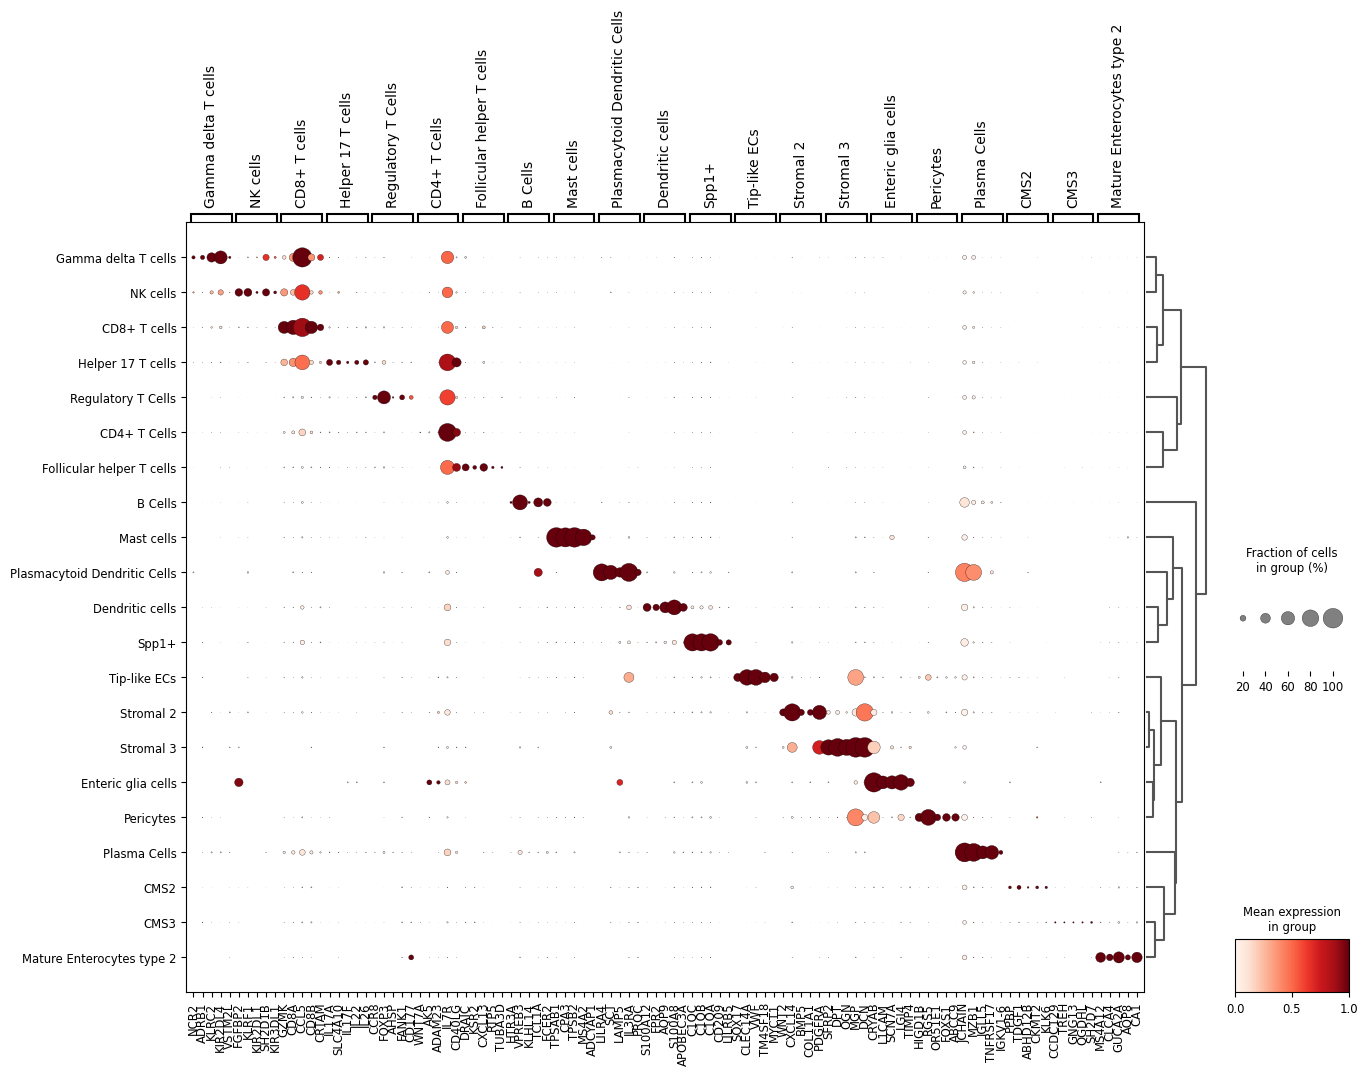

✅ Dotplot saved!


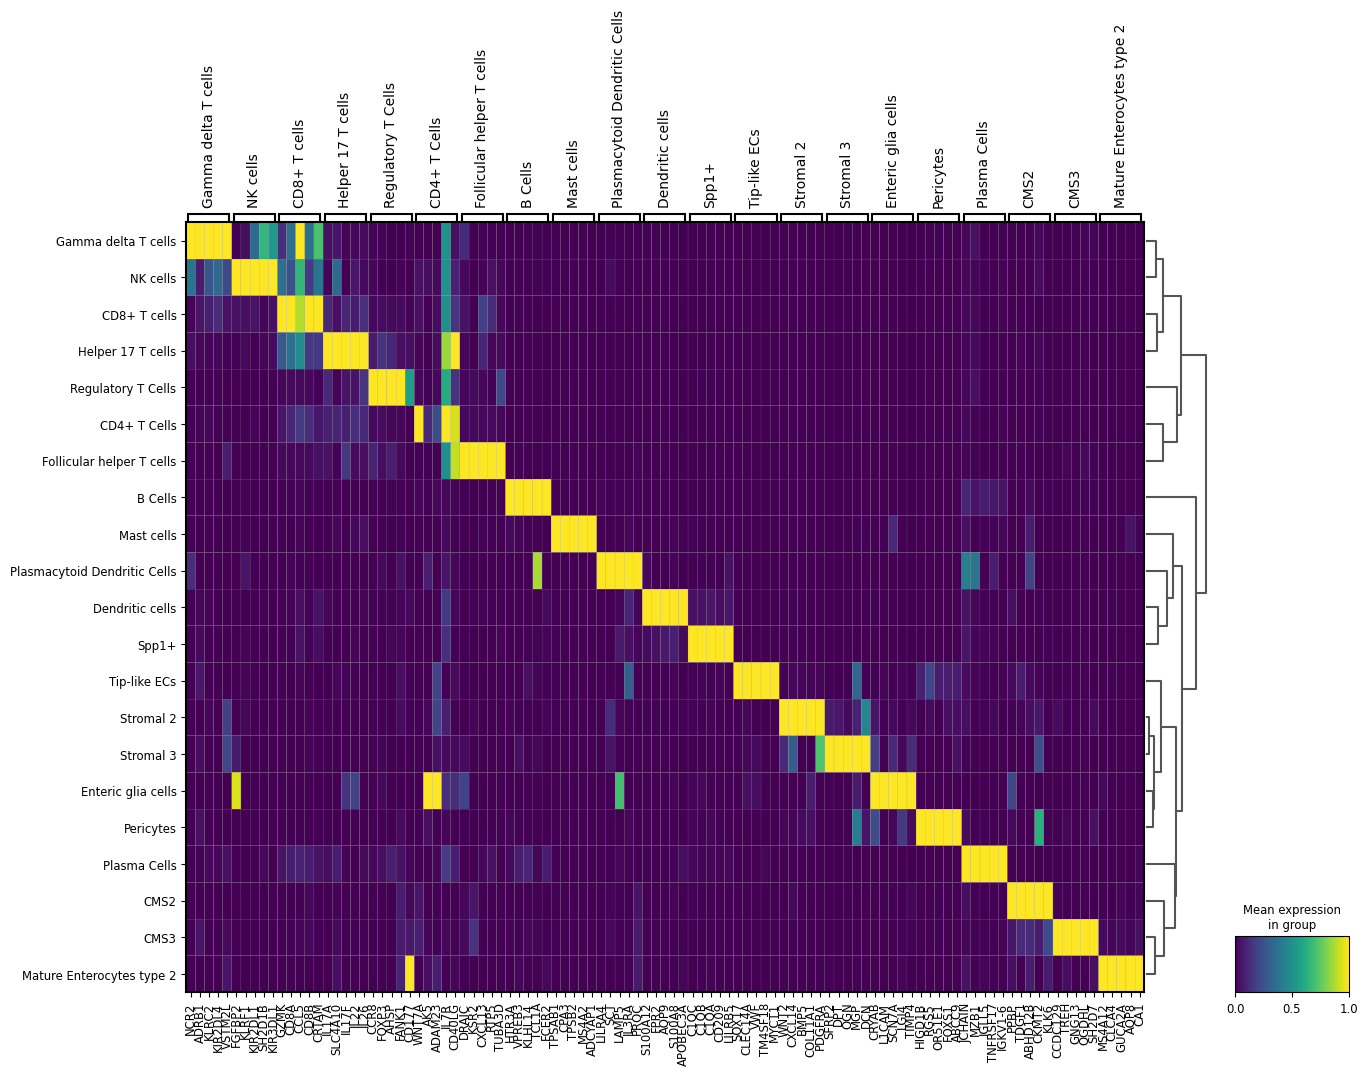

✅ Matrixplot saved!


In [17]:

# Get top 5 markers per cell type
top_markers_dict = {}

for cell_type in all_degs['Cell_Type'].unique():
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    sig_degs = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (ct_degs['logfoldchanges'] > 1)  # Only positive markers
    ]
    
    if len(sig_degs) > 0:
        top5 = sig_degs.nlargest(5, 'logfoldchanges')['names'].tolist()
        top_markers_dict[cell_type] = top5

# Create ordered dict for dotplot
marker_genes = {ct: genes for ct, genes in top_markers_dict.items()}

# Dotplot
sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    groupby='Cell_Type',
    dendrogram=True,
    standard_scale='var',
    figsize=(15, 10),
    save='_celltype_markers_top5.pdf'
)

print("✅ Dotplot saved!")

# Alternative: Matrixplot
sc.pl.matrixplot(
    adata,
    var_names=marker_genes,
    groupby='Cell_Type',
    dendrogram=True,
    standard_scale='var',
    figsize=(15, 10),
    save='_celltype_markers_matrix.pdf'
)

print("✅ Matrixplot saved!")


SUMMARY: Marker Genes Per Cell Type
                   Cell_Type  n_cells  UP_markers  DOWN_genes  total_sig
                   Stromal 2      897        3996         857       4853
                        CMS3     3876        3705        2570       6275
                        CMS2     1792        3461        1495       4956
                Tip-like ECs      610        3448         734       4182
                   Pericytes      457        2775         697       3472
                       Spp1+     1634        2429        1033       3462
             Dendritic cells     2105        1548        2199       3747
           Helper 17 T cells     2377        1457         466       1923
                Plasma Cells      240        1335         167       1502
          Regulatory T Cells     3907        1198        1022       2220
         Gamma delta T cells     1336        1168         342       1510
                     B Cells    10774        1126        3311       4437
Plasmacytoid D

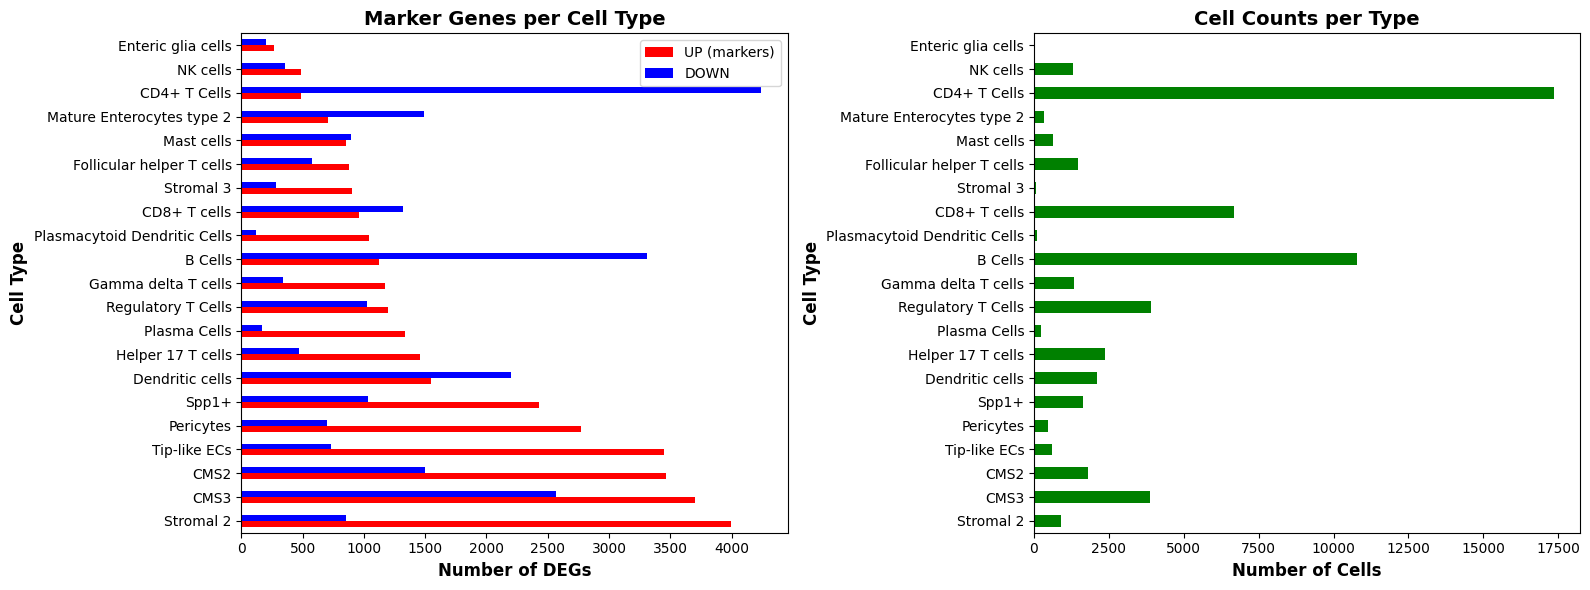


✅ Summary saved to 'summary_markers_per_celltype.csv'


In [18]:


# Create summary
summary_data = []

for cell_type in all_degs['Cell_Type'].unique():
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    sig_up = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (ct_degs['logfoldchanges'] > 0.5)
    ]
    
    sig_down = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (ct_degs['logfoldchanges'] < -0.5)
    ]
    
    n_cells = ct_degs['n_cells'].iloc[0]
    
    summary_data.append({
        'Cell_Type': cell_type,
        'n_cells': n_cells,
        'UP_markers': len(sig_up),
        'DOWN_genes': len(sig_down),
        'total_sig': len(sig_up) + len(sig_down)
    })

summary_df = pd.DataFrame(summary_data).sort_values('UP_markers', ascending=False)

print("\n" + "="*60)
print("SUMMARY: Marker Genes Per Cell Type")
print("="*60)
print(summary_df.to_string(index=False))

# Visualize summary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of markers
summary_df_plot = summary_df.set_index('Cell_Type')
summary_df_plot[['UP_markers', 'DOWN_genes']].plot(
    kind='barh',
    stacked=False,
    ax=ax1,
    color=['red', 'blue']
)
ax1.set_xlabel('Number of DEGs', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cell Type', fontsize=12, fontweight='bold')
ax1.set_title('Marker Genes per Cell Type', fontsize=14, fontweight='bold')
ax1.legend(['UP (markers)', 'DOWN'])

# Cell counts
summary_df.plot(
    x='Cell_Type',
    y='n_cells',
    kind='barh',
    ax=ax2,
    color='green',
    legend=False
)
ax2.set_xlabel('Number of Cells', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cell Type', fontsize=12, fontweight='bold')
ax2.set_title('Cell Counts per Type', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('summary_markers_celltype.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Save summary
summary_df.to_csv('summary_markers_per_celltype.csv', index=False)
print("\n✅ Summary saved to 'summary_markers_per_celltype.csv'")